In [1]:
#import requests
#import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import scipy.stats
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score ,f1_score ,roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def Convert_Time(row): 
    tokens = row.split(':')
    if len(tokens) ==2:
        return int(tokens[0]) + int(tokens[1])/60
    
def Rest_days(row):
    if isinstance(row,int) or isinstance(row,float):
        return row
    tokens = row.split(' ')
    return int(tokens[0])

def get_matches_played_in_szn(df):
    df = df.copy()
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            team_df['Matches_Played'] = 1
            gd_cum = team_df['Matches_Played'].cumsum()
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    #cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum

def get_cum_by_col(df,grouper,grouper_name,cols,agg_func):
    df = df.copy()
    gp_arr=[]
    for team,team_df in df.groupby('Team'):
        for g,gd in team_df.groupby([grouper])[cols]:
            #print(g)
            #display(gd)
            if agg_func == 'sum':
                gd_cum = gd.shift(1).cumsum()
            if agg_func == 'mean':
                gd_cum = gd.shift(1).expanding().mean()
            for col in cols:
                gd_cum[col].fillna(gd_cum[col].mean(), inplace=True)
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    alias = '_this_'+grouper_name+'_'+agg_func
    cum_cols = [col+alias for col in cols]
    cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum 

def rolling_average_or_sum(df,cols,window,agg_func):
    df = df.copy()
    alias = '_last_'+str(window)+'gm_'+agg_func
    new_cols = [col+alias for col in cols]
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            #for g,gd in team_df.groupby([grouper])[cols]:
                if agg_func == 'sum':
                    rolling = team_df[cols].shift(1).rolling(window).sum()
                if agg_func == 'mean':
                    rolling = team_df[cols].shift(1).rolling(window).mean()
                    
                rolling.columns = new_cols   
                gp_arr.append(rolling)
    #display(rolling)
    rolling_df = pd.concat(gp_arr)
    rolling_df = rolling_df.sort_index()
    #rolling.columns = new_cols
    df_rolling = pd.concat([df,rolling_df],axis=1)
    return df_rolling

def Similar_Category2d(df,column,similar_categories_2d_array,category_array):
    df=df.copy()
    for idx,similar_categories1d in enumerate(similar_categories_2d_array):
        rows_with_matches = df[column].isin(similar_categories1d)
        df.loc[rows_with_matches,column] = category_array[idx]
        return df
    
def Cat_Code(df,columns):
    df=df.copy()
    for col in columns:
        new_feature = col+'_code'
        df[new_feature] = df[col].astype("category").cat.codes
    return df

def get_Cum_Sum_Avg(df,cols,agg_func):
    df = df.copy()
    for col in cols:
        new_feature = col+'_Total_'+agg_func
        if agg_func == 'sum':
            df[new_feature] = df[col].shift(1).cumsum()
        if agg_func == 'mean':
            df[new_feature] = df[col].shift(1).expanding().mean()
    return df

def missing_percentage(df):
    """A function for returning missing ratios."""
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


In [6]:
def Feature_Engineering(df):
    df=df.copy()
    #First_Match_In_Month
    first_occurence_idx = []
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            for column,column_df in team_df.groupby('Month'):
                first_occurence_idx.append(column_df.index[0])
                
    df.loc[first_occurence_idx,'First_Match_In_Month'] = 1
    df['First_Match_In_Month'].replace(np.nan, 0, inplace=True)
    
    #First_Match_With_Formation
    first_occurence_idx = []
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            for column,column_df in team_df.groupby('Formation'):
                first_occurence_idx.append(column_df.index[0])
    
    df.loc[first_occurence_idx,'First_Match_With_Formation'] = 1
    df['First_Match_With_Formation'].replace(np.nan, 0, inplace=True)
    
    #Gameweek
    df = get_matches_played_in_szn(df)
    
    #Opponent
    mask = df['Opponent'].str.contains('eng')
    df.loc[mask,'Opponent'] = df.loc[mask,'Opponent'].replace('eng ',"",regex=True) 
    
    df['Opponent_Count'] =  df['Opponent'].map(df.Opponent.value_counts().to_dict())
    
    arr = ['zeros','ones','twos','threes','fours','fives','sixs','sevens','eights','nines']
    no = [str(x) for x  in list(range(0,10))]
    no_dict = dict(zip(no,arr))
    for key,value in df.Opponent.value_counts().to_dict().items():
        if value <10:
            #print(key,no_dict[str(value)])
            mask = df.Opponent==key
            df.loc[mask,'Opponent'] = no_dict[str(value)]
    
    #top4 and top 7
    top7 = ['Chelsea','Manchester City','Liverpool','Tottenham','Manchester Utd','Arsenal','Leicester City']
    top4 = ['Chelsea','Manchester City','Liverpool','Manchester Utd']
    
    df['Top7_Opp'] = df.apply(lambda x : 1 if x.Opponent in top7  else 0 ,axis=1)
    df['Top7_Team'] = df.apply(lambda x : 1 if x.Team in top7  else 0 ,axis=1)
    df['Top4_Opp'] = df.apply(lambda x : 1 if x.Opponent in top4  else 0 ,axis=1)
    df['Top4_Team'] = df.apply(lambda x : 1 if x.Team in top4  else 0 ,axis=1)
    #------------------------->>>>>>>>>>>>>>>>>.
    
    #Referees
    df['Referee_Count'] =  df['Referee'].map(df.Referee.value_counts().to_dict())
    
    for key,value in df.Referee.value_counts().to_dict().items():
        if value <10:
            #print(key,no_dict[str(value)])
            mask = df.Referee==key
            df.loc[mask,'Referee'] = no_dict[str(value)]

    #ref_ranking
    top_refs = ['Michael Oliver','Anthony Taylor','Darren England','Paul Tierney','Andre Marriner',
            'Andy Madley','Stuart Attwell','Mike Dean','Craig Pawson','Martin Atkinson','Jonathan Moss',
            'David Coote','Kevin Friend','Jarred Gillett','Robert Jones','Peter Bankes','Graham Scott',
            'Chris Kavanagh','Simon Hooper',
           ]
    ref_Ranking = [8,7.5,7,7,6.5,6,5.5,5.5,5,5,5,5,5,5,4.5,4.5,4,4,4,]
    df['top20_Ref'] = df.apply(lambda x : 1 if x.Referee in top_refs  else 0 ,axis=1)
    df['top5_Ref'] = df.apply(lambda x : 1 if x.Referee in top_refs[:5]  else 0 ,axis=1)
    
    lg = ['Post_Season_Cup', 'Premier League', 'Europa', 'EFL Cup', 'FA Cup',
       'Champions Lg']
    df['Ref_rank'] = df['Referee'].map(dict(zip(top_refs,ref_Ranking)))
    rank_na = [7,3,6,5,5,7]
    for comp,rank in zip(lg,rank_na):
            mask = (df.Comp==comp)
            df.loc[mask,'Ref_rank'] = df.loc[mask,'Ref_rank'].fillna(rank)

    #---------------------->>>>>>>>>>>>>>>>> 
    #Time
    df.loc[:,'Time'] = df.Time.apply(Convert_Time)
    #Rest
    df.loc[:,'Rest'] = df.Rest.apply(Rest_days)
    
    #Comp
    df = Similar_Category2d(df,column='Comp',
                   similar_categories_2d_array=[['Europa Lg','Conf Lg'],['Community Shield','Super Cup']],
                   category_array=['Europa','Post_Season_Cup'])
    
    #drop ['Prev_match_date',Prev_comp',Prev_Opp']
    df.drop(['Prev_match_date','Prev_comp','Prev_Opp'],axis=1,inplace=True)
    
    #Prev_comp',Prev_Opp'
    df['Prev_comp'] = df.Comp.shift(1)
    df['Prev_Opp'] = df.Opponent.shift(1)
    
    #captain
    df['Captain_Count'] =  df['Captain'].map(df.Captain.value_counts().to_dict())
    df['Captain_Rank'] = df['Captain_Rank'].astype("category").cat.codes
    
    #get_cum_by_col
    df=get_cum_by_col(df=df,grouper='Comp',grouper_name='Comp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Top7_Opp',grouper_name='7_Opp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Top4_Opp',grouper_name='4_Opp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Ref_rank',grouper_name='Ref',cols=['Win','Lose','Draw','GF','GA'],agg_func='sum')
    
    df = get_cum_by_col(df,grouper='Comp',grouper_name='Comp',cols=['Poss','GF','GA','Win','Lose'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Top7_Opp',grouper_name='7_Opp',cols=['Poss','GF','GA','Win','Lose','Draw'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Ref_rank',grouper_name='Ref_rank',cols=['Poss','GF','GA','Win','Lose','Draw'],agg_func='mean')
    
    #cat_code
    cat_cols = ['Comp','Day','Venue','Opponent','Captain','Formation','Referee','Team','Prev_comp', 'Prev_Opp']
    df = Cat_Code(df=df,columns=cat_cols)
    
    #Month is a cyclic feature
    ##Gabriel Atkin
    df.loc[:,'Cyclic_Month'] = (-np.cos(0.5236 * df['Month']))
    
    #advance_stats_rolling
    #fillna
    """
    for col in advance_stats_cols:
        df[col].replace(np.nan, 0, inplace=True)
    
    df = rolling_average_or_sum(df=df,cols=advance_stats_cols,window=2,agg_func='sum') #last2gm
    df = rolling_average_or_sum(df=df,cols=advance_stats_cols,window=3,agg_func='mean') #lats3gm
    
    df = get_Cum_Sum_Avg(df=df,cols=advance_stats_cols,agg_func='sum') # cum sum
    df = get_Cum_Sum_Avg(df=df,cols=advance_stats_cols,agg_func='mean') #cum avg"""
    
    #Na_Count
    df['Na_count'] = df.apply(lambda x :len(x) - x.count(),axis=1)
    
    #fill_na
    fill_with_zero = 'Total_Points	Total_GF	Total_GA	Total_Win	Total_Draw	Total_Loss	Points_Avg_for_szn	GF_Avg_for_szn	GA_Avg_for_szn	Win_Avg_for_szn	Draw_Avg_for_szn	Loss_Avg_for_szn'.split('	')
    for col in fill_with_zero:
        df[col].replace(np.nan, 0, inplace=True)
    
    return df

In [7]:
def predictions(data,predictors,targets,model):
    data = data.copy()
    train = data[data["Season"] < 2022]
    test = data[data["Season"] == 2022]
    combination = []
    for target in targets:
        model.fit(train[predictors], train[target])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        error = accuracy_score(test[target], preds)
        print(f"{target} Accuracy Score : ",error)
        print()
        col ="predicted_"+target
        combined = pd.DataFrame(dict(actual=test[target], predicted=preds))
        combined.columns = ['actual',col]
        combination.append(combined) 
        display(pd.crosstab(index=combined["actual"], columns=combined[col]))
        if target == 'Points':
            print(f"{target} Precision _Macro_Micro : ",precision_score(test[target], preds, average = 'macro'),precision_score(test[target], preds, average = 'micro'))# print("Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score _Macro_Micro : ",f1_score(test[target], preds, average = 'macro'),f1_score(test[target], preds, average = 'micro'))
            #print(f"{target} ROC _Macro_Micro : ",roc_auc_score(test[target], preds, average = 'macro'),roc_auc_score(test[target], preds, average = 'micro'))
        else:
            print(f"{target} Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score : ",f1_score(test[target], preds))
            print(f"{target} ROC : ",roc_auc_score(test[target], preds))
        print()
        print()
    combinations = pd.concat(combination,axis=1)
    combinations = combinations.merge(test[["Team", "Opponent", "Result"]], left_index=True, right_index=True)
    return combinations

In [67]:
def make_mi_scores_Classif(X_train, y_train):
    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X_train.dtypes == int
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(20,14))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def apply_pca(X,alias, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC_{alias}{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    #print( pca.components_)
    return pca, X_pca, loadings

def topk_feat(df,mi_scores,PC,cols,thresh,targets):
    df = df.copy()
    mi_scores = mi_scores.copy()
    topk = mi_scores[mi_scores>thresh].index.to_list()
    base_df = pd.concat([df.loc[:,cols].reset_index(drop=True),PC],axis=1)
    #display(base_df.head(2))
    base_df = base_df[topk]
    out_df = pd.concat([df.loc[:,targets+['Season']].reset_index(drop=True),base_df],axis=1)
    return  out_df

def Ratio(df_def,a,b,ratio_name):
    df_def = df_def.copy()
    new_feature = ratio_name
    df_def[new_feature] = df_def[a]/df_def[b]
    mask = (df_def[b]==0)
    df_def.loc[mask,new_feature]=0 
    return df_def

In [ ]:
def with_PCA(df):
    df = df.copy()

In [9]:
df  = pd.read_csv("C:\\Users\\user\\Solo Dolo\\EPL Analysis\\All_team_data2.csv")
df.shape

(4783, 249)

In [10]:
df2 = Feature_Engineering(df=df)
df2.shape

(4783, 328)

In [11]:
drops =['Unnamed: 0','Date','Round','Poss','Attendance','Notes','Attendance','xG','xGA','Match Report']
advance_stats_cols = 'Standard_Gls	Standard_Sh	Standard_SoT	Standard_SoT%	Standard_G/Sh	Standard_G/SoT	Standard_Dist	Standard_FK	Standard_PK	Standard_PKatt	Expected_xG	Expected_npxG	Expected_npxG/Sh	Expected_G-xG	Expected_np:G-xG	SCA_Types_SCA	SCA_Types_PassLive	SCA_Types_PassDead	SCA_Types_Drib	SCA_Types_Sh	SCA_Types_Fld	SCA_Types_Def	GCA_Types_GCA	GCA_Types_PassLive	GCA_Types_PassDead	GCA_Types_Drib	GCA_Types_Sh	GCA_Types_Fld	GCA_Types_Def	Tackles_Tkl	Tackles_TklW	Tackles_Def_3rd	Tackles_Mid_3rd	Tackles_Att_3rd	Vs_Dribbles_Tkl	Vs_Dribbles_Att	Vs_Dribbles_Tkl%	Vs_Dribbles_Past	Pressures_Press	Pressures_Succ	Pressures_%	Pressures_Def_3rd	Pressures_Mid_3rd	Pressures_Att_3rd	Blocks_Blocks	Blocks_Sh	Blocks_ShSv	Blocks_Pass	Def_Int	Def_Tkl+Int	Def_Clr	Def_Err	GK_Perf_SoTA	GK_Perf_GA	GK_Perf_Saves	GK_Perf_Save%	GK_Perf_CS	GK_Perf_PSxG	GK_Perf_PSxG+/-	GK_Penalty_PKatt	GK_Penalty_PKA	GK_Penalty_PKsv	GK_Penalty_PKm	GK_Launch_Cmp	GK_Launch_Att	GK_Launch_Cmp%	GK_Passes_Att	GK_Passes_Thr	GK_Passes_Launch%	GK_Passes_AvgLen	Gk_Goal_Kk_Att	Gk_Goal_Kk_Launch%	Gk_Goal_Kk_AvgLen	GK_Crosses_Opp	GK_Crosses_Stp	GK_Crosses_Stp%	Gk_Sweeper_#OPA	Gk_Sweeper_AvgDist	Passing_Total_Cmp	Passing_Total_Att	Passing_Total_Cmp%	Passing_Total_TotDist	Passing_Total_PrgDist	Passing_Short_Cmp	Passing_Short_Att	Passing_Short_Cmp%	Passing_Medium_Cmp	Passing_Medium_Att	Passing_Medium_Cmp%	Passing_Long_Cmp	Passing_Long_Att	Passing_Long_Cmp%	Passing_Ast	Passing_xA	Passing_KP	Passing_1/3	Passing_PPA	Passing_CrsPA	Passing_Prog	Misc_Stats_CrdY	Misc_Stats_CrdR	Misc_Stats_2CrdY	Misc_Stats_Fls	Misc_Stats_Fld	Misc_Stats_Off	Misc_Stats_Crs	Misc_Stats_Int	Misc_Stats_TklW	Misc_Stats_PKwon	Misc_Stats_PKcon	Misc_Stats_OG	Misc_Stats_Recov	Misc_Stats_Aerial_DuelsWon	Misc_Stats_Aerial_DuelsLost	Misc_Stats_Aerial_DuelsWon%'.split('	')
drops.extend(advance_stats_cols)
df3 = df2.drop(drops,axis=1)
df4 = df3.dropna()
df4.shape

(3779, 204)

In [12]:
predictors = df4.columns.drop([ 'Result',
 'GF',
 'GA', 'Win',
 'Draw',
 'Lose',
 'Points', 'Away_Win',
 'Away_Draw',
 'Away_Loss',
 'Home_Win',
 'Home_Draw',
 'Home_Loss','Result','Comp','Day','Venue','Opponent','Captain','Formation','Referee','Team','Prev_comp', 'Prev_Opp'])

In [14]:
predictors.to_list()

['Time',
 'Season',
 'Month',
 'Total_Points',
 'Total_GF',
 'Total_GA',
 'Total_Win',
 'Total_Draw',
 'Total_Loss',
 'Points_Avg_for_szn',
 'GF_Avg_for_szn',
 'GA_Avg_for_szn',
 'Win_Avg_for_szn',
 'Draw_Avg_for_szn',
 'Loss_Avg_for_szn',
 'Points_last_1gm_sum',
 'Win_last_1gm_sum',
 'Draw_last_1gm_sum',
 'Lose_last_1gm_sum',
 'GF_last_1gm_sum',
 'GA_last_1gm_sum',
 'Away_Win_last_1gm_sum',
 'Away_Draw_last_1gm_sum',
 'Away_Loss_last_1gm_sum',
 'Home_Win_last_1gm_sum',
 'Home_Draw_last_1gm_sum',
 'Home_Loss_last_1gm_sum',
 'Points_last_2gm_sum',
 'Win_last_2gm_sum',
 'Draw_last_2gm_sum',
 'Lose_last_2gm_sum',
 'GF_last_2gm_sum',
 'GA_last_2gm_sum',
 'Away_Win_last_2gm_sum',
 'Away_Draw_last_2gm_sum',
 'Away_Loss_last_2gm_sum',
 'Home_Win_last_2gm_sum',
 'Home_Draw_last_2gm_sum',
 'Home_Loss_last_2gm_sum',
 'Points_last_3gm_mean',
 'Win_last_3gm_mean',
 'Draw_last_3gm_mean',
 'Lose_last_3gm_mean',
 'GF_last_3gm_mean',
 'GA_last_3gm_mean',
 'Away_Win_last_3gm_mean',
 'Away_Draw_last_3gm

In [15]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=1)

In [16]:
first_batch = predictions(data=df4,predictors=predictors,targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.7617765814266487



predicted_Win,0.0,1.0
actual,,
0,427,20
1,157,139


Win Precision :  0.8742138364779874
Win F1_score :  0.6109890109890109
Win ROC :  0.7124259326440534


Draw Accuracy Score :  0.8398384925975774



predicted_Draw,0.0,1.0
actual,,
0,569,1
1,118,55


Draw Precision :  0.9821428571428571
Draw F1_score :  0.4803493449781659
Draw ROC :  0.6580823445897982


Lose Accuracy Score :  0.7765814266487214



predicted_Lose,0.0,1.0
actual,,
0,458,11
1,155,119


Lose Precision :  0.9153846153846154
Lose F1_score :  0.5891089108910891
Lose ROC :  0.7054262057802748


Points Accuracy Score :  0.41184387617765816



predicted_Points,0.0,1.0
actual,,
0,274,0
1,141,32
3,296,0


Points Precision _Macro_Micro :  0.4617909048288795 0.41184387617765816
Points F1_score _Macro_Micro :  0.2895134332053981 0.41184387617765816




In [24]:
totals ='Total_Points	Total_GF	Total_GA	Total_Win	Total_Draw	Total_Loss'.split('	')
X_total = df4.loc[:,totals]

In [20]:
pca_total, X_pca_total, loadings_total = apply_pca(X=X_total,alias='total')
display(loadings_total)

,PC_total1,PC_total2,PC_total3,PC_total4,PC_total5,PC_total6
Total_Points,0.471714,-0.299215,0.067714,0.259911,0.297820,-7.260311e-01
Total_GF,0.469415,-0.289964,0.107216,-0.361011,-0.744141,5.551115e-17
Total_GA,0.387941,0.482794,0.179603,-0.652015,0.398787,-2.081668e-16
Total_Win,0.451062,-0.351615,0.192171,0.258896,0.323636,6.813319e-01
Total_Draw,0.377655,0.239848,-0.878400,0.132237,-0.045943,9.308954e-02
Total_Loss,0.246084,0.641982,0.378347,0.540814,-0.302780,2.428613e-17


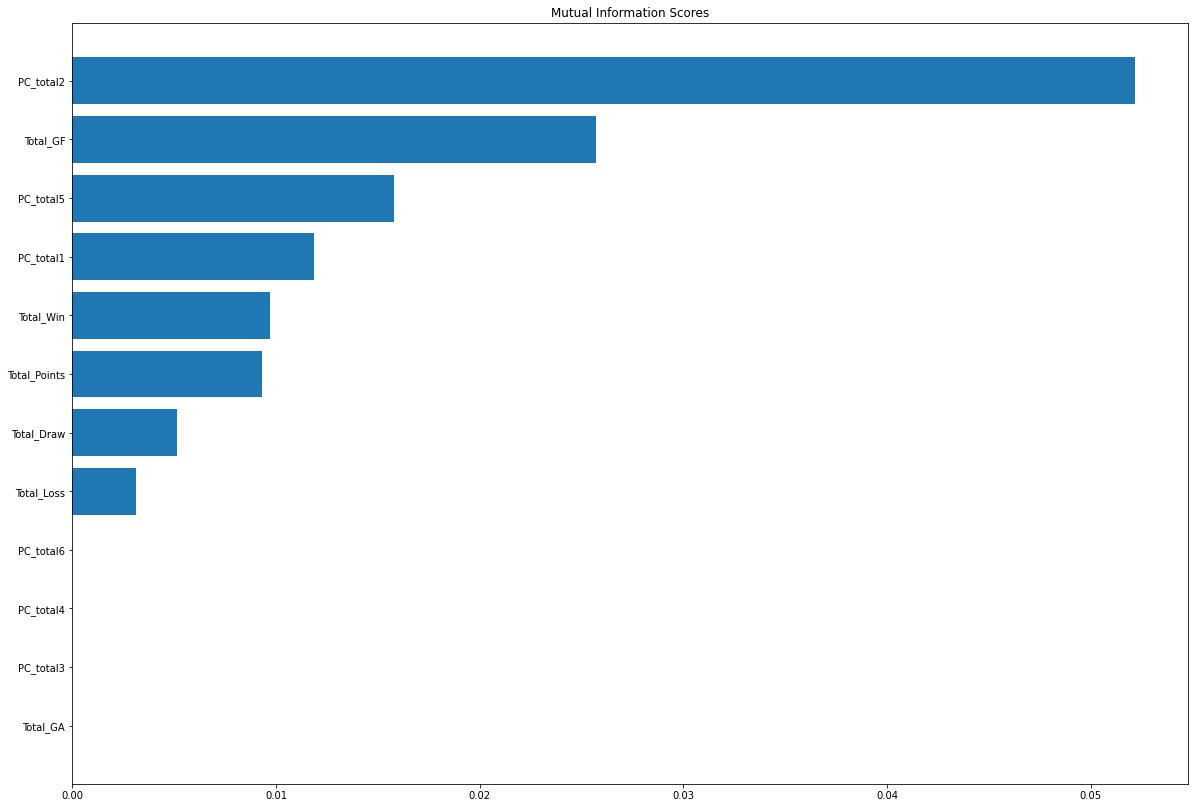

In [21]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_total.reset_index(drop=True),X_pca_total],axis=1), y_train=df4['Points'])
plot_mi_scores(scores=mi_scores_win)

In [22]:
targets=['Win','Draw','Lose','Points']

In [68]:
a1 = topk_feat(df=df4,mi_scores=mi_scores_win,PC=X_pca_total,cols=totals,thresh=0,targets=targets)

In [56]:
def total_variable(new_df):
    new_df = new_df.copy()
    new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_Win',ratio_name='Tot_Pts/Win')
    new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_Loss',ratio_name='Tot_Pts/Loss')
    new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_Draw',ratio_name='Tot_Pts/Draw')
    new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_GF',ratio_name='Tot_Pts/GF')
    #new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_GA',ratio_name='Tot_Pts/GA')
    new_df = Ratio(df_def=new_df,a='Total_Win',b='Total_Loss',ratio_name='Tot_Win/Loss')
    new_df = Ratio(df_def=new_df,a='Total_Win',b='Total_Draw',ratio_name='Tot_Win/Draw')
    new_df = Ratio(df_def=new_df,a='Total_Draw',b='Total_Loss',ratio_name='Tot_Draw/Loss')
    new_df = Ratio(df_def=new_df,a='Total_Win',b='Total_GF',ratio_name='Tot_Win/GF')
    #new_df = Ratio(df_def=new_df,a='Total_Loss',b='Total_GA',ratio_name='Tot_Loss/GA')
    new_df = Ratio(df_def=new_df,a='Total_Draw',b='Total_GF',ratio_name='Tot_Draw/GF')
    #new_df = Ratio(df_def=new_df,a='Total_GF',b='Total_GA',ratio_name='Tot_GF/GA')
    #new_df['GF_GA_+-'] = new_df['GF'] - new_df['GA']
    return new_df

In [71]:
a2=total_variable(new_df=a1)

In [72]:
a2.head()

,Win,Draw,Lose,Points,Season,PC_total2,Total_GF,PC_total5,PC_total1,Total_Win,Total_Points,Total_Draw,Total_Loss,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Draw/GF
0,1,0,0,3,2018,-0.528511,5.0,0.040984,-3.039429,1.0,4.0,1.0,2.0,4.000000,2.0,4.0,0.800000,0.5,1.0,0.5,0.200000,0.200000
1,0,1,0,1,2018,-0.704516,11.0,0.043462,-2.718043,3.0,10.0,1.0,2.0,3.333333,5.0,10.0,0.909091,1.5,3.0,0.5,0.272727,0.090909
2,1,0,0,3,2018,-0.730496,12.0,0.083289,-2.480631,4.0,14.0,2.0,2.0,3.500000,7.0,7.0,1.166667,2.0,2.0,1.0,0.333333,0.166667
3,1,0,0,3,2018,-0.879360,18.0,0.108186,-2.137435,6.0,20.0,2.0,2.0,3.333333,10.0,10.0,1.111111,3.0,3.0,1.0,0.333333,0.111111
4,0,0,1,0,2018,-0.970816,20.0,0.124181,-2.004026,7.0,23.0,2.0,2.0,3.285714,11.5,11.5,1.150000,3.5,3.5,1.0,0.350000,0.100000


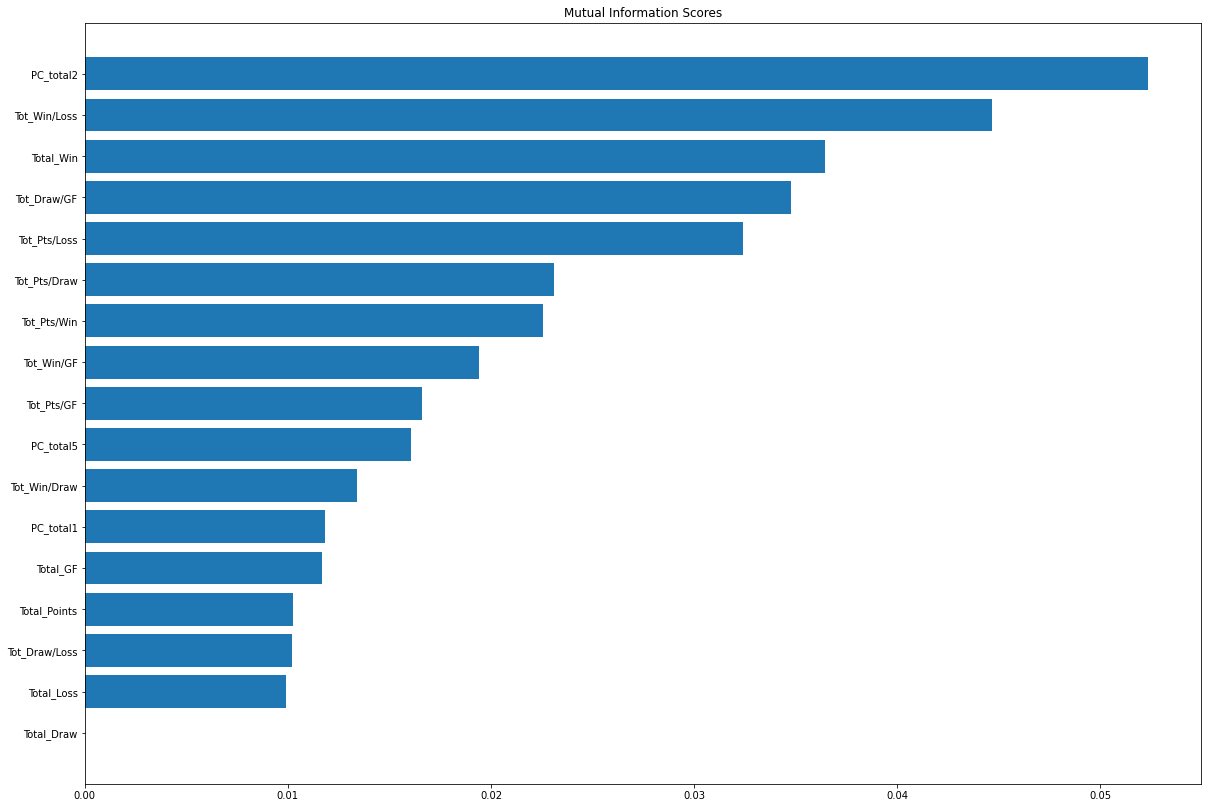

In [47]:
#win
mi_ = make_mi_scores_Classif(X_train=a2.drop(targets,axis=1), y_train=df4['Points'])
plot_mi_scores(scores=mi_)

In [73]:
first_batch1 = predictions(data=a2,predictors=a2.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.639300134589502



predicted_Win,0.0,1.0
actual,,
0,396,51
1,217,79


Win Precision :  0.6076923076923076
Win F1_score :  0.37089201877934275
Win ROC :  0.5763989660801742


Draw Accuracy Score :  0.765814266487214



predicted_Draw,0.0,1.0
actual,,
0,569,1
1,173,0


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.49912280701754386


Lose Accuracy Score :  0.6312247644683715



predicted_Lose,0.0,1.0
actual,,
0,433,36
1,238,36


Lose Precision :  0.5
Lose F1_score :  0.20809248554913293
Lose ROC :  0.5273138997400899


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [74]:
szn_avg = 'Points_Avg_for_szn	GF_Avg_for_szn	GA_Avg_for_szn	Win_Avg_for_szn	Draw_Avg_for_szn	Loss_Avg_for_szn'.split('	')
szn_avg

['Points_Avg_for_szn',
 'GF_Avg_for_szn',
 'GA_Avg_for_szn',
 'Win_Avg_for_szn',
 'Draw_Avg_for_szn',
 'Loss_Avg_for_szn']

In [75]:
X_szn_avg = df4.loc[:,szn_avg]

In [80]:
pca_szn_avg, X_pca_szn_avg, loadings_szn_avg = apply_pca(X=X_szn_avg,alias='szn_avg')
display(loadings_szn_avg)

,PC_szn_avg1,PC_szn_avg2,PC_szn_avg3,PC_szn_avg4,PC_szn_avg5,PC_szn_avg6
Points_Avg_for_szn,0.477284,-0.016018,0.040056,-0.341406,3.864624e-01,7.102305e-01
GF_Avg_for_szn,0.428951,-0.070706,0.598196,0.673174,1.387779e-16,2.220446e-16
GA_Avg_for_szn,-0.396505,-0.202669,0.771584,-0.454276,-1.804112e-16,-1.110223e-16
Win_Avg_for_szn,0.469035,-0.177706,0.004858,-0.321854,4.039521e-01,-6.939995e-01
Draw_Avg_for_szn,-0.122825,0.897442,0.180009,0.012567,3.694247e-01,-1.023486e-01
Loss_Avg_for_szn,-0.442611,-0.341595,-0.113086,0.346646,7.422903e-01,5.883857e-02


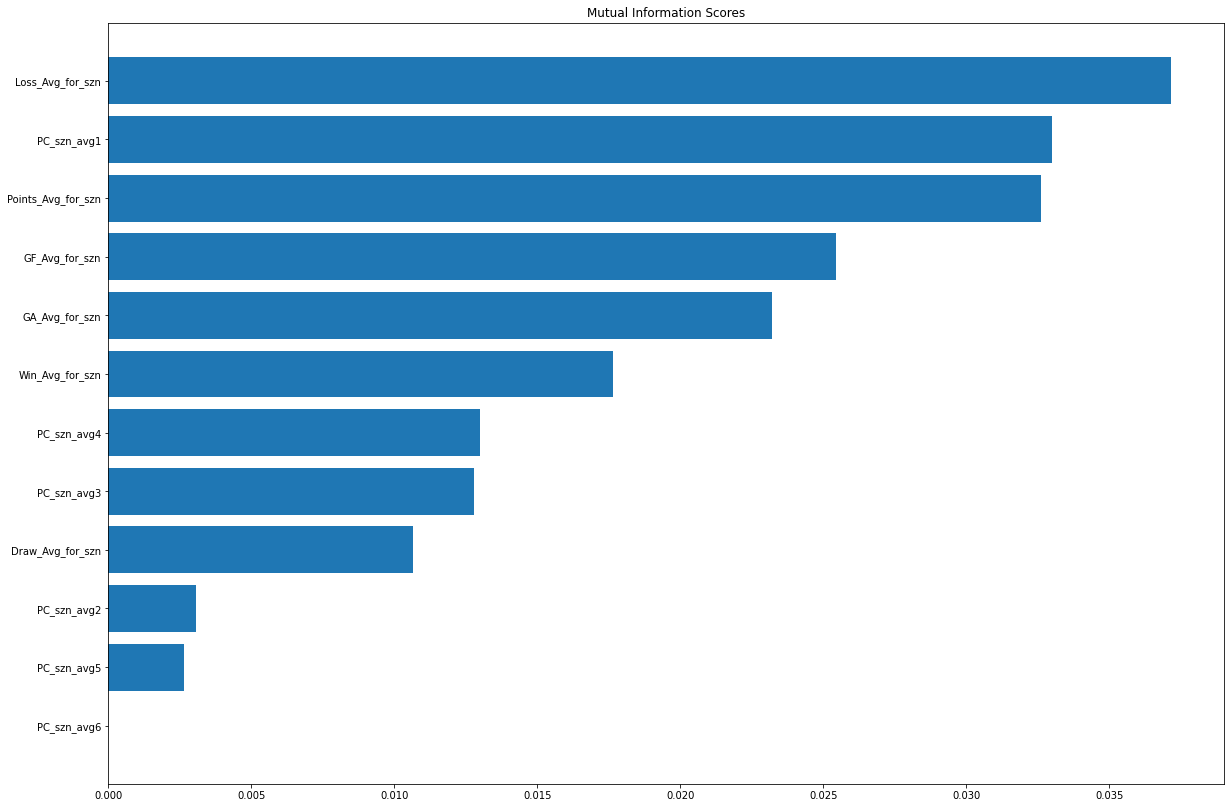

In [81]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_szn_avg.reset_index(drop=True),X_pca_szn_avg],axis=1), y_train=df4['Points'])
plot_mi_scores(scores=mi_scores_win)

In [82]:
b1 = topk_feat(df=df4,mi_scores=mi_scores_win,PC=X_pca_szn_avg,cols=szn_avg,thresh=0,targets=targets)

In [84]:
b1.columns

Index(['Win', 'Draw', 'Lose', 'Points', 'Season', 'Loss_Avg_for_szn',
       'PC_szn_avg1', 'Points_Avg_for_szn', 'GF_Avg_for_szn', 'GA_Avg_for_szn',
       'Win_Avg_for_szn', 'PC_szn_avg4', 'PC_szn_avg3', 'Draw_Avg_for_szn',
       'PC_szn_avg2', 'PC_szn_avg5'],
      dtype='object')

In [87]:
def szn_avg_variable(new_df):
    new_df = new_df.copy()
    new_df = Ratio(df_def=new_df,a='Points_Avg_for_szn',b='Win_Avg_for_szn',ratio_name='Avg_Pts/Win')
    new_df = Ratio(df_def=new_df,a='Points_Avg_for_szn',b='Loss_Avg_for_szn',ratio_name='Avg_Pts/Loss')
    new_df = Ratio(df_def=new_df,a='Points_Avg_for_szn',b='GF_Avg_for_szn',ratio_name='Avg_Pts/GF')
    new_df = Ratio(df_def=new_df,a='Points_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_Pts/GA')
    new_df = Ratio(df_def=new_df,a='Win_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_Win/GA')
    new_df = Ratio(df_def=new_df,a='Win_Avg_for_szn',b='GF_Avg_for_szn',ratio_name='Avg_Win/GF')
    new_df = Ratio(df_def=new_df,a='Win_Avg_for_szn',b='Loss_Avg_for_szn',ratio_name='Avg_Win/Loss')
    new_df = Ratio(df_def=new_df,a='Win_Avg_for_szn',b='Draw_Avg_for_szn',ratio_name='Avg_Win/Draw')
    new_df = Ratio(df_def=new_df,a='Loss_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_Loss/GA')
    new_df = Ratio(df_def=new_df,a='Loss_Avg_for_szn',b='GF_Avg_for_szn',ratio_name='Avg_Loss/GF')
    new_df = Ratio(df_def=new_df,a='Draw_Avg_for_szn',b='GF_Avg_for_szn',ratio_name='Avg_Draw/GF')
    new_df = Ratio(df_def=new_df,a='Draw_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_Draw/GA')
    new_df = Ratio(df_def=new_df,a='GF_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_GF/GA')
    new_df['Avg_GF_GA+-'] = new_df.GF_Avg_for_szn - new_df.GA_Avg_for_szn
    return new_df

In [88]:
b2 = szn_avg_variable(new_df=b1)

In [93]:
b2.head()

,Win,Draw,Lose,Points,Season,Loss_Avg_for_szn,PC_szn_avg1,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,PC_szn_avg4,PC_szn_avg3,Draw_Avg_for_szn,PC_szn_avg2,PC_szn_avg5,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-
0,1,0,0,3,2018,0.500000,-2.549352,1.000000,1.250000,2.250000,0.250000,-0.488050,1.472260,0.250000,-0.389574,2.496314e-14,4.000000,2.0,0.800000,0.444444,0.111111,0.200000,0.5,1.0,0.222222,0.400000,0.200000,0.111111,0.555556,-1.000000
1,0,1,0,1,2018,0.333333,0.216998,1.666667,1.833333,1.666667,0.500000,-0.331915,0.956871,0.166667,-0.810921,1.025364e-16,3.333333,5.0,0.909091,1.000000,0.300000,0.272727,1.5,3.0,0.200000,0.181818,0.090909,0.100000,1.100000,0.166667
2,1,0,0,3,2018,0.250000,0.577499,1.750000,1.500000,1.250000,0.500000,-0.452519,0.001401,0.250000,0.332896,-1.898224e-15,3.500000,7.0,1.166667,1.400000,0.400000,0.333333,2.0,2.0,0.200000,0.166667,0.166667,0.200000,1.200000,0.250000
3,1,0,0,3,2018,0.200000,1.511335,2.000000,1.800000,1.200000,0.600000,-0.481207,0.182111,0.200000,-0.115829,1.607262e-14,3.333333,10.0,1.111111,1.666667,0.500000,0.333333,3.0,3.0,0.166667,0.111111,0.111111,0.166667,1.500000,0.600000
4,0,0,1,0,2018,0.181818,1.874637,2.090909,1.818182,1.090909,0.636364,-0.493152,-0.024608,0.181818,-0.221089,8.342657e-18,3.285714,11.5,1.150000,1.916667,0.583333,0.350000,3.5,3.5,0.166667,0.100000,0.100000,0.166667,1.666667,0.727273


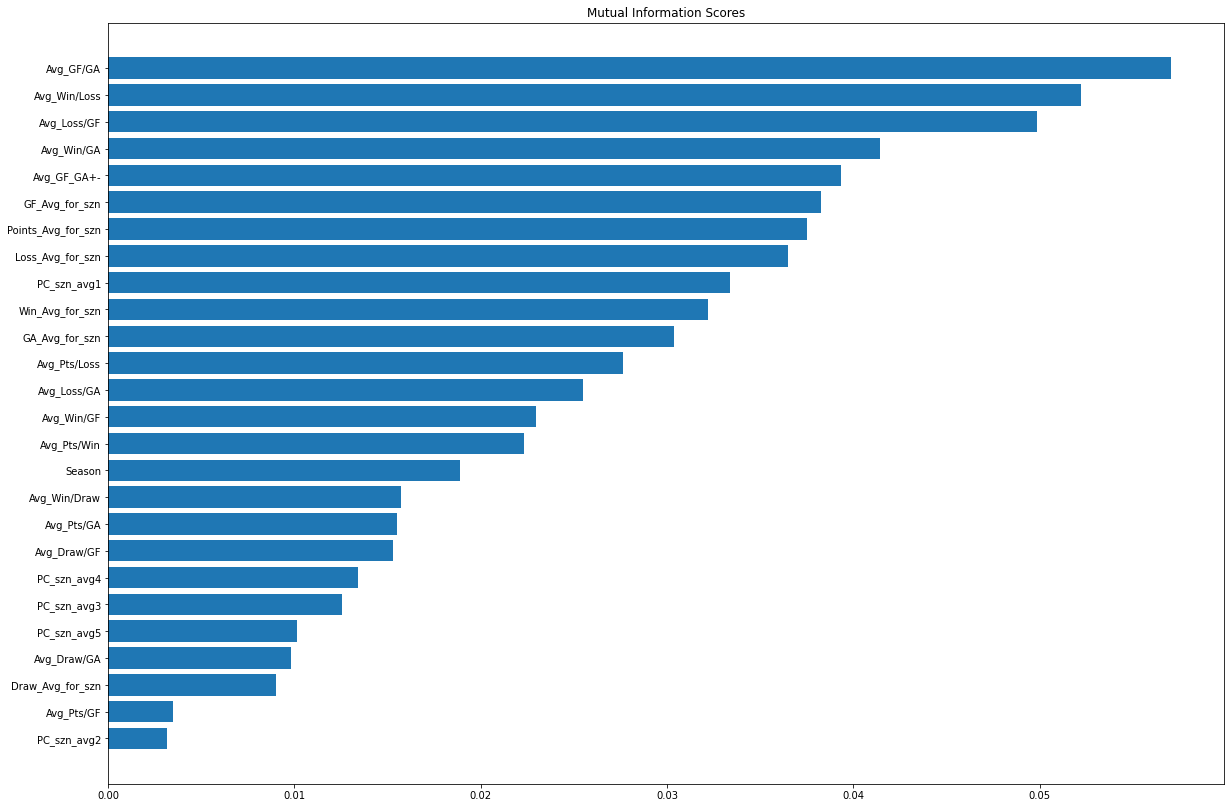

In [90]:
#win
mi_ = make_mi_scores_Classif(X_train=b2.drop(targets,axis=1), y_train=df4['Points'])
plot_mi_scores(scores=mi_)

In [91]:
first_batch2 = predictions(data=b2,predictors=b2.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.5814266487213997



predicted_Win,0.0,1.0
actual,,
0,382,65
1,246,50


Win Precision :  0.43478260869565216
Win F1_score :  0.24330900243309003
Win ROC :  0.5117525243364169


Draw Accuracy Score :  0.7604306864064603



predicted_Draw,0.0,1.0
actual,,
0,564,6
1,172,1


Draw Precision :  0.14285714285714285
Draw F1_score :  0.011111111111111112
Draw ROC :  0.4976270155156678


Lose Accuracy Score :  0.6231493943472409



predicted_Lose,0.0,1.0
actual,,
0,430,39
1,241,33


Lose Precision :  0.4583333333333333
Lose F1_score :  0.19075144508670522
Lose ROC :  0.5186411529422751


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [95]:
a_b = pd.concat([a2.drop(targets+['Season'],axis=1),b2],axis=1)
a_b.head(2)

,PC_total2,Total_GF,PC_total5,PC_total1,Total_Win,Total_Points,Total_Draw,Total_Loss,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Draw/GF,Win,Draw,Lose,Points,Season,Loss_Avg_for_szn,PC_szn_avg1,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,PC_szn_avg4,PC_szn_avg3,Draw_Avg_for_szn,PC_szn_avg2,PC_szn_avg5,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-
0,-0.528511,5.0,0.040984,-3.039429,1.0,4.0,1.0,2.0,4.000000,2.0,4.0,0.800000,0.5,1.0,0.5,0.200000,0.200000,1,0,0,3,2018,0.500000,-2.549352,1.000000,1.250000,2.250000,0.25,-0.488050,1.472260,0.250000,-0.389574,2.496314e-14,4.000000,2.0,0.800000,0.444444,0.111111,0.200000,0.5,1.0,0.222222,0.400000,0.200000,0.111111,0.555556,-1.000000
1,-0.704516,11.0,0.043462,-2.718043,3.0,10.0,1.0,2.0,3.333333,5.0,10.0,0.909091,1.5,3.0,0.5,0.272727,0.090909,0,1,0,1,2018,0.333333,0.216998,1.666667,1.833333,1.666667,0.50,-0.331915,0.956871,0.166667,-0.810921,1.025364e-16,3.333333,5.0,0.909091,1.000000,0.300000,0.272727,1.5,3.0,0.200000,0.181818,0.090909,0.100000,1.100000,0.166667


In [96]:
first_batch2 = predictions(data=a_b,predictors=a_b.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6029609690444145



predicted_Win,0.0,1.0
actual,,
0,388,59
1,236,60


Win Precision :  0.5042016806722689
Win F1_score :  0.2891566265060241
Win ROC :  0.535355825624282


Draw Accuracy Score :  0.765814266487214



predicted_Draw,0.0,1.0
actual,,
0,568,2
1,172,1


Draw Precision :  0.3333333333333333
Draw F1_score :  0.011363636363636362
Draw ROC :  0.5011357874454924


Lose Accuracy Score :  0.6285329744279946



predicted_Lose,0.0,1.0
actual,,
0,425,44
1,232,42


Lose Precision :  0.4883720930232558
Lose F1_score :  0.23333333333333334
Lose ROC :  0.5297340202013914


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

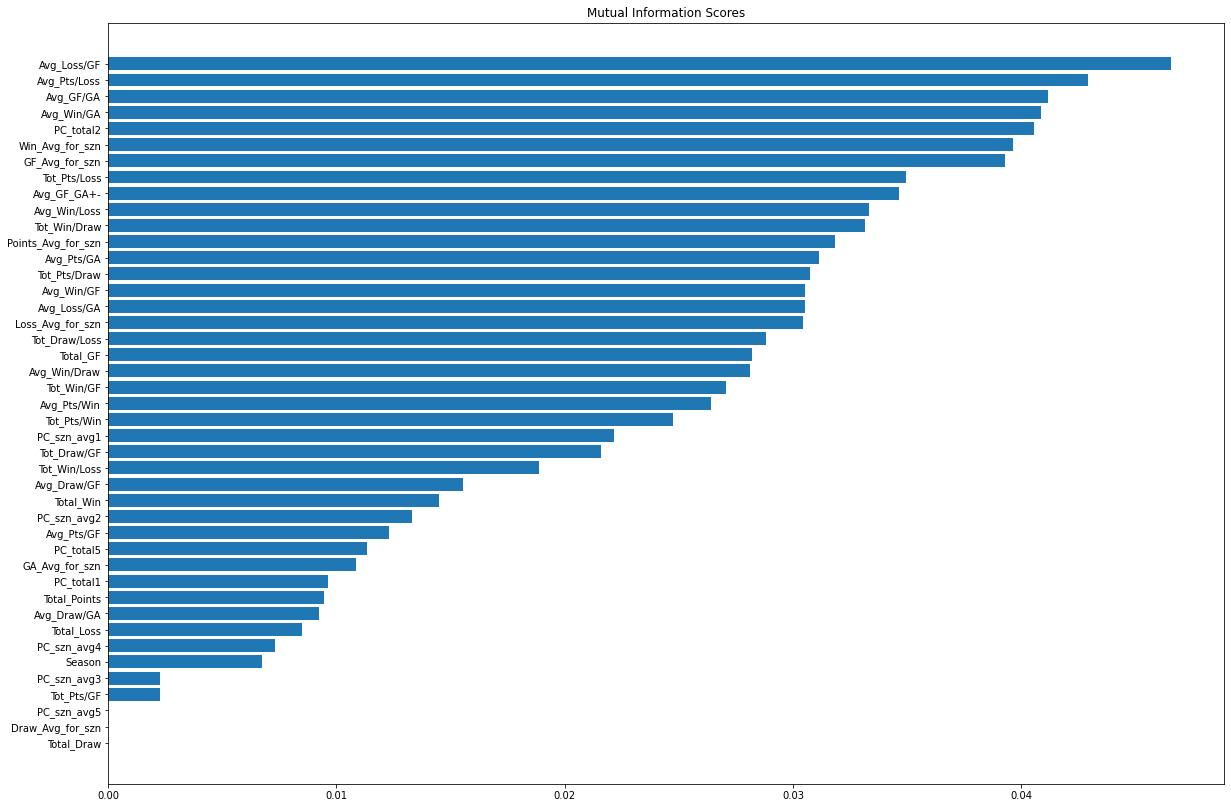

In [98]:
#win
mi_ = make_mi_scores_Classif(X_train=a_b.drop(targets,axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_)

In [99]:
roll_2game = 'Points_last_2gm_sum	Win_last_2gm_sum	Draw_last_2gm_sum	Lose_last_2gm_sum	GF_last_2gm_sum	GA_last_2gm_sum	Away_Win_last_2gm_sum	Away_Draw_last_2gm_sum	Away_Loss_last_2gm_sum	Home_Win_last_2gm_sum	Home_Draw_last_2gm_sum	Home_Loss_last_2gm_sum'.split('	')
#cluster_list.append(roll_2game)
roll_2game  

['Points_last_2gm_sum',
 'Win_last_2gm_sum',
 'Draw_last_2gm_sum',
 'Lose_last_2gm_sum',
 'GF_last_2gm_sum',
 'GA_last_2gm_sum',
 'Away_Win_last_2gm_sum',
 'Away_Draw_last_2gm_sum',
 'Away_Loss_last_2gm_sum',
 'Home_Win_last_2gm_sum',
 'Home_Draw_last_2gm_sum',
 'Home_Loss_last_2gm_sum']

In [100]:
X_2gm = df4.loc[:,roll_2game] 

In [101]:
pca_2gm, X_pca_2gm, loadings_2gm = apply_pca(X=X_2gm,alias='2gm')
display(loadings_2gm)

,PC_2gm1,PC_2gm2,PC_2gm3,PC_2gm4,PC_2gm5,PC_2gm6,PC_2gm7,PC_2gm8,PC_2gm9,PC_2gm10,PC_2gm11,PC_2gm12
Points_last_2gm_sum,0.438909,-0.044939,0.001825,0.009956,-0.004962,-0.010342,-0.217193,0.020814,-0.360604,-0.043832,7.288296e-01,-3.071641e-01
Win_last_2gm_sum,0.415113,-0.204717,0.005202,0.008099,-0.003496,-0.041973,-0.198258,0.061318,-0.327022,-0.193146,-6.639395e-01,-3.946834e-01
Draw_last_2gm_sum,-0.050545,0.610499,-0.013182,0.003769,-0.003894,0.121318,-0.001705,-0.157753,-0.010835,0.571096,-1.068209e-01,-4.972399e-01
Lose_last_2gm_sum,-0.385807,-0.294744,0.005559,-0.011466,0.006827,-0.057240,0.205668,0.067489,0.345889,-0.274030,1.287673e-01,-7.089624e-01
GF_last_2gm_sum,0.325601,-0.108214,0.002934,-0.001905,-0.003395,0.686201,0.641376,-0.000998,0.003700,0.000494,1.942890e-16,-1.249001e-16
GA_last_2gm_sum,-0.310012,-0.166988,-0.000077,0.010382,-0.036089,0.700133,-0.620003,0.001369,-0.002371,0.000508,5.551115e-17,3.747003e-16
Away_Win_last_2gm_sum,0.252159,-0.116091,0.609738,0.251091,-0.328322,-0.036508,-0.115246,-0.473375,0.374152,0.040346,-1.387779e-16,-2.706169e-16
Away_Draw_last_2gm_sum,-0.025936,0.418525,-0.021506,-0.547502,-0.441647,0.074660,0.000362,-0.213407,-0.043707,-0.525228,-6.938894e-17,-3.295975e-17
Away_Loss_last_2gm_sum,-0.278536,-0.220129,-0.369571,0.341035,-0.422638,-0.056003,0.166355,-0.468358,-0.432578,0.071814,-5.828671e-16,-3.885781e-16
Home_Win_last_2gm_sum,0.281226,-0.145477,-0.560766,-0.224211,0.303378,-0.018891,-0.146736,-0.507884,0.401734,0.041913,-1.942890e-16,-5.204170e-16


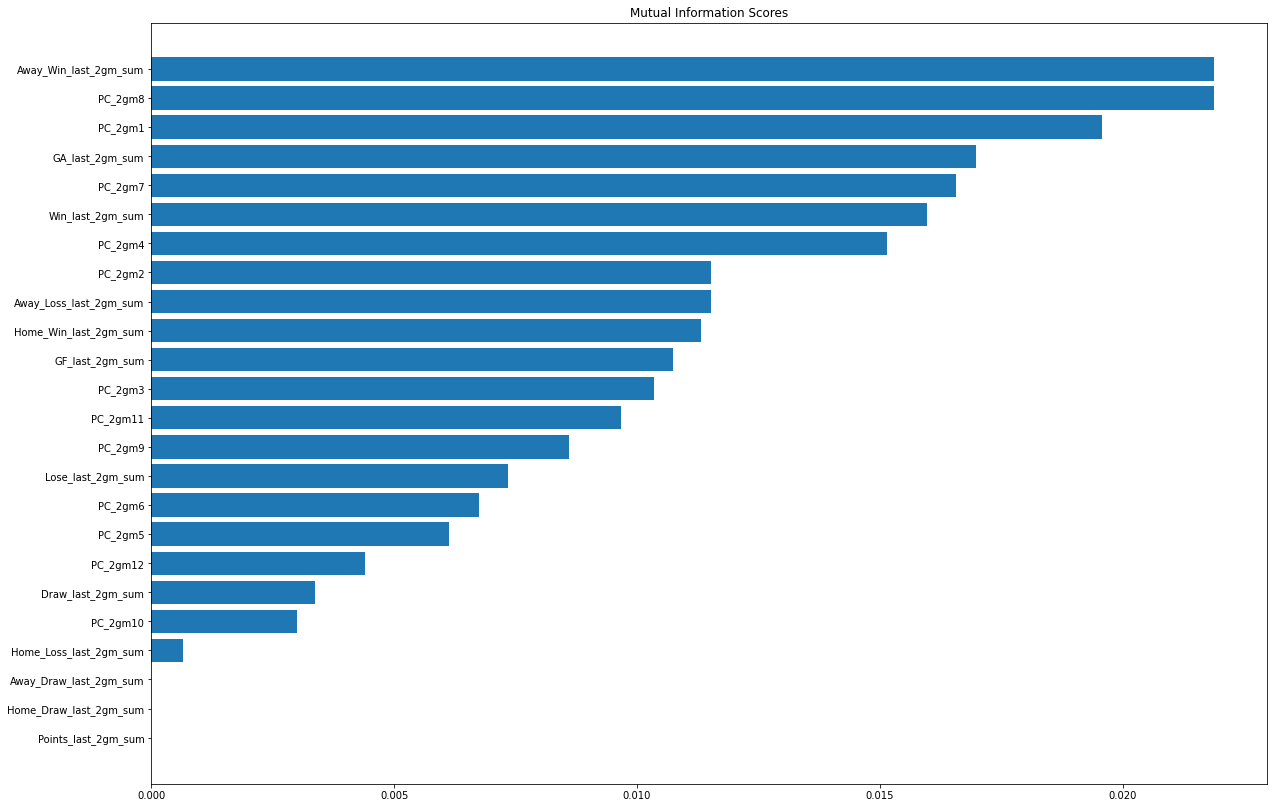

In [123]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_2gm.reset_index(drop=True),X_pca_2gm],axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_scores_win)

In [125]:
c1.columns

Index(['Win', 'Draw', 'Lose', 'Points', 'Season', 'Away_Win_last_2gm_sum',
       'PC_2gm8', 'PC_2gm1', 'GA_last_2gm_sum', 'PC_2gm7', 'Win_last_2gm_sum',
       'PC_2gm4', 'PC_2gm2', 'Away_Loss_last_2gm_sum', 'Home_Win_last_2gm_sum',
       'GF_last_2gm_sum', 'PC_2gm3', 'PC_2gm11', 'PC_2gm9',
       'Lose_last_2gm_sum', 'PC_2gm6', 'PC_2gm5', 'PC_2gm12',
       'Draw_last_2gm_sum', 'PC_2gm10', 'Home_Loss_last_2gm_sum'],
      dtype='object')

In [128]:
def l2gm_variable(new_df):
    new_df = new_df.copy()
    new_df = Ratio(df_def=new_df,a='Win_last_2gm_sum',b='GA_last_2gm_sum',ratio_name='l2_Win/GA')
    new_df = Ratio(df_def=new_df,a='Win_last_2gm_sum',b='GF_last_2gm_sum',ratio_name='l2_Win/GF')
    new_df = Ratio(df_def=new_df,a='Win_last_2gm_sum',b='Lose_last_2gm_sum',ratio_name='l2_Win/Loss')
    new_df = Ratio(df_def=new_df,a='Win_last_2gm_sum',b='Draw_last_2gm_sum',ratio_name='l2g_Win/Draw')
    new_df = Ratio(df_def=new_df,a='Lose_last_2gm_sum',b='GA_last_2gm_sum',ratio_name='l2g_Loss/GA')
    new_df = Ratio(df_def=new_df,a='Lose_last_2gm_sum',b='GF_last_2gm_sum',ratio_name='l2g_Loss/GF')
    new_df = Ratio(df_def=new_df,a='Draw_last_2gm_sum',b='GF_last_2gm_sum',ratio_name='l2g_Draw/GF')
    new_df = Ratio(df_def=new_df,a='Draw_last_2gm_sum',b='GA_last_2gm_sum',ratio_name='l2g_Draw/GA')
    new_df = Ratio(df_def=new_df,a='GF_last_2gm_sum',b='GA_last_2gm_sum',ratio_name='l2g_GF/GA')
    new_df['l2g_GF_GA+-'] = new_df.GF_last_2gm_sum - new_df.GA_last_2gm_sum
    return new_df

In [124]:
c1 = topk_feat(df=df4,mi_scores=mi_scores_win,PC=X_pca_2gm,cols=roll_2game,thresh=0,targets=targets)

In [104]:
c1.head() 

,Win,Draw,Lose,Points,Season,Home_Win_last_2gm_sum,PC_2gm1,Points_last_2gm_sum,PC_2gm3,Home_Loss_last_2gm_sum,GA_last_2gm_sum,PC_2gm8,PC_2gm10,Win_last_2gm_sum,PC_2gm2,PC_2gm9,PC_2gm6,Draw_last_2gm_sum,PC_2gm5,Away_Loss_last_2gm_sum,PC_2gm7,Away_Win_last_2gm_sum,Lose_last_2gm_sum,Home_Draw_last_2gm_sum,PC_2gm4
0,1,0,0,3,2018,0.0,-3.672907,0.0,-1.275876,0.0,5.0,-0.008231,0.001595,0.0,-1.502376,-0.002323,-0.392406,0.0,-1.544597,2.0,-0.233234,0.0,2.0,0.0,1.212043
1,0,1,0,1,2018,2.0,3.487078,6.0,-1.834498,0.0,1.0,-0.007532,-0.002703,2.0,-1.015318,0.004520,0.250175,0.0,1.048458,0.0,0.175127,0.0,0.0,0.0,-0.733380
2,1,0,0,3,2018,1.0,1.221616,4.0,-0.966763,0.0,0.0,-0.004310,-0.005086,1.0,1.920212,-0.000459,-1.360960,1.0,-0.453631,0.0,-0.335342,0.0,0.0,0.0,-1.626987
3,1,0,0,3,2018,1.0,3.297509,6.0,0.237667,0.0,2.0,-0.007801,0.000007,2.0,-1.072505,0.003496,0.603767,0.0,-0.089793,0.0,-0.129570,1.0,0.0,0.0,0.114274
4,0,0,1,0,2018,1.0,3.297509,6.0,0.237667,0.0,2.0,-0.007801,0.000007,2.0,-1.072505,0.003496,0.603767,0.0,-0.089793,0.0,-0.129570,1.0,0.0,0.0,0.114274


In [129]:
c2 = l2gm_variable(new_df=c1)

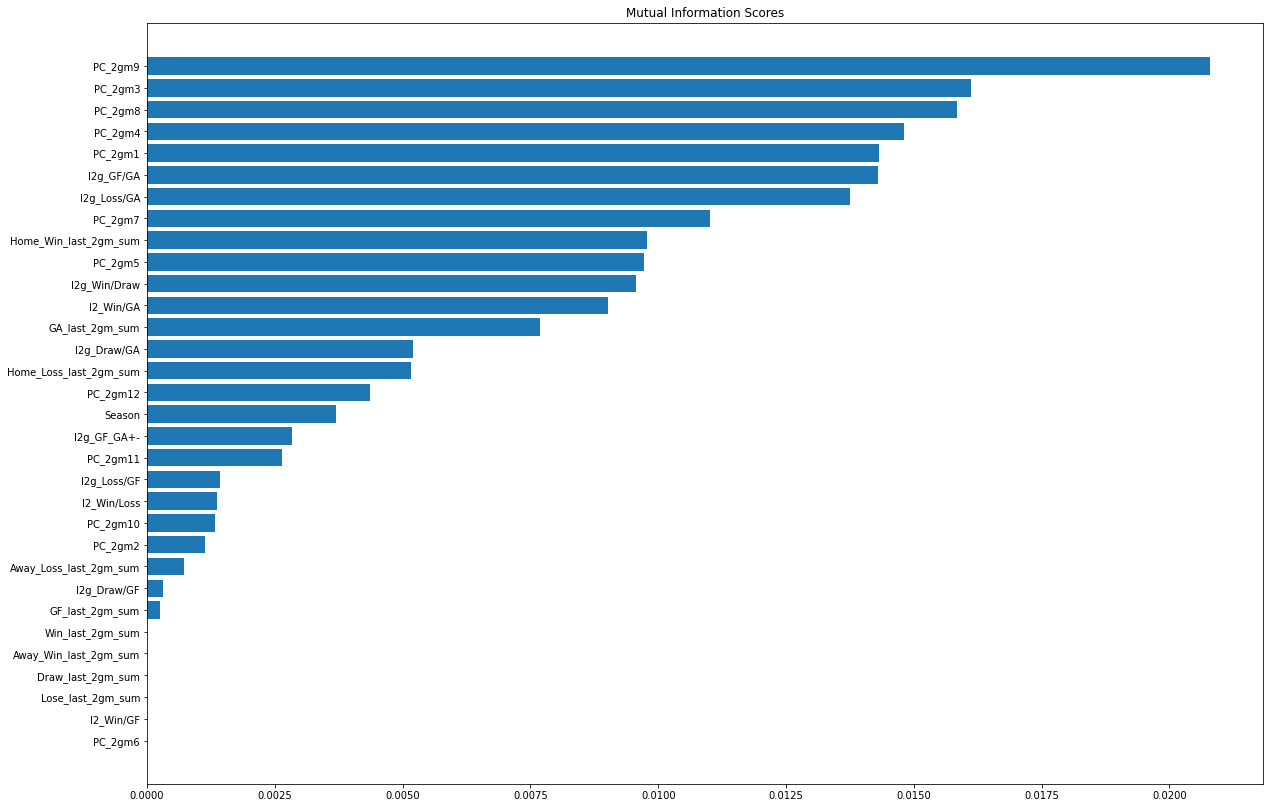

In [131]:
#win
mi_ = make_mi_scores_Classif(X_train=c2.drop(targets,axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_)

In [105]:
first_batch3 = predictions(data=c1,predictors=c1.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.604306864064603



predicted_Win,0.0,1.0
actual,,
0,401,46
1,248,48


Win Precision :  0.5106382978723404
Win F1_score :  0.24615384615384614
Win ROC :  0.5296269423786203


Draw Accuracy Score :  0.7617765814266487



predicted_Draw,0.0,1.0
actual,,
0,564,6
1,171,2


Draw Precision :  0.25
Draw F1_score :  0.022099447513812154
Draw ROC :  0.5005171889260724


Lose Accuracy Score :  0.6137281292059219



predicted_Lose,0.0,1.0
actual,,
0,419,50
1,237,37


Lose Precision :  0.42528735632183906
Lose F1_score :  0.20498614958448752
Lose ROC :  0.5142133441240098


Points Accuracy Score :  0.3633916554508748



predicted_Points,0.0,1.0
actual,,
0,268,6
1,171,2
3,296,0


Points Precision _Macro_Micro :  0.20487528344671202 0.3633916554508748
Points F1_score _Macro_Micro :  0.18443949208504673 0.3633916554508748




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [130]:
first_batch3 = predictions(data=c2,predictors=c2.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.5989232839838493



predicted_Win,0.0,1.0
actual,,
0,398,49
1,249,47


Win Precision :  0.4895833333333333
Win F1_score :  0.23979591836734693
Win ROC :  0.5245820484914445


Draw Accuracy Score :  0.7590847913862718



predicted_Draw,0.0,1.0
actual,,
0,562,8
1,171,2


Draw Precision :  0.2
Draw F1_score :  0.02185792349726776
Draw ROC :  0.49876280296116016


Lose Accuracy Score :  0.6150740242261103



predicted_Lose,0.0,1.0
actual,,
0,417,52
1,234,40


Lose Precision :  0.43478260869565216
Lose F1_score :  0.2185792349726776
Lose ROC :  0.5175556005167073


Points Accuracy Score :  0.3633916554508748



predicted_Points,0.0,1.0
actual,,
0,268,6
1,171,2
3,296,0


Points Precision _Macro_Micro :  0.20487528344671202 0.3633916554508748
Points F1_score _Macro_Micro :  0.18443949208504673 0.3633916554508748




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [132]:
a_b_c = pd.concat([a_b.drop(targets+['Season'],axis=1),c2],axis=1)
a_b_c.head(2)

,PC_total2,Total_GF,PC_total5,PC_total1,Total_Win,Total_Points,Total_Draw,Total_Loss,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Draw/GF,Loss_Avg_for_szn,PC_szn_avg1,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,PC_szn_avg4,PC_szn_avg3,Draw_Avg_for_szn,PC_szn_avg2,PC_szn_avg5,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-,Win,Draw,Lose,Points,Season,Away_Win_last_2gm_sum,PC_2gm8,PC_2gm1,GA_last_2gm_sum,PC_2gm7,Win_last_2gm_sum,PC_2gm4,PC_2gm2,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,GF_last_2gm_sum,PC_2gm3,PC_2gm11,PC_2gm9,Lose_last_2gm_sum,PC_2gm6,PC_2gm5,PC_2gm12,Draw_last_2gm_sum,PC_2gm10,Home_Loss_last_2gm_sum,l2_Win/GA,l2_Win/GF,l2_Win/Loss,l2g_Win/Draw,l2g_Loss/GA,l2g_Loss/GF,l2g_Draw/GF,l2g_Draw/GA,l2g_GF/GA,l2g_GF_GA+-
0,-0.528511,5.0,0.040984,-3.039429,1.0,4.0,1.0,2.0,4.000000,2.0,4.0,0.800000,0.5,1.0,0.5,0.200000,0.200000,0.500000,-2.549352,1.000000,1.250000,2.250000,0.25,-0.488050,1.472260,0.250000,-0.389574,2.496314e-14,4.000000,2.0,0.800000,0.444444,0.111111,0.200000,0.5,1.0,0.222222,0.400000,0.200000,0.111111,0.555556,-1.000000,1,0,0,3,2018,0.0,-0.008231,-3.672907,5.0,-0.233234,0.0,1.212043,-1.502376,2.0,0.0,0.0,-1.275876,4.675781e-13,-0.002323,2.0,-0.392406,-1.544597,1.002608e-15,0.0,0.001595,0.0,0.0,0.000000,0.0,0.0,0.4,0.0,0.0,0.0,0.0,-5.0
1,-0.704516,11.0,0.043462,-2.718043,3.0,10.0,1.0,2.0,3.333333,5.0,10.0,0.909091,1.5,3.0,0.5,0.272727,0.090909,0.333333,0.216998,1.666667,1.833333,1.666667,0.50,-0.331915,0.956871,0.166667,-0.810921,1.025364e-16,3.333333,5.0,0.909091,1.000000,0.300000,0.272727,1.5,3.0,0.200000,0.181818,0.090909,0.100000,1.100000,0.166667,0,1,0,1,2018,0.0,-0.007532,3.487078,1.0,0.175127,2.0,-0.733380,-1.015318,0.0,2.0,6.0,-1.834498,-7.343836e-15,0.004520,0.0,0.250175,1.048458,6.007665e-14,0.0,-0.002703,0.0,2.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0


In [107]:
first_batch2 = predictions(data=a_b_c,predictors=a_b_c.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6164199192462988



predicted_Win,0.0,1.0
actual,,
0,403,44
1,241,55


Win Precision :  0.5555555555555556
Win F1_score :  0.2784810126582279
Win ROC :  0.5436884031682688


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.6312247644683715



predicted_Lose,0.0,1.0
actual,,
0,443,26
1,248,26


Lose Precision :  0.5
Lose F1_score :  0.15950920245398773
Lose ROC :  0.5197267053678428


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [133]:
first_batch2 = predictions(data=a_b_c,predictors=a_b_c.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6271870794078062



predicted_Win,0.0,1.0
actual,,
0,410,37
1,240,56


Win Precision :  0.6021505376344086
Win F1_score :  0.2879177377892031
Win ROC :  0.5532075699860936


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.629878869448183



predicted_Lose,0.0,1.0
actual,,
0,444,25
1,250,24


Lose Precision :  0.4897959183673469
Lose F1_score :  0.14860681114551083
Lose ROC :  0.5171431684123698


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [108]:
roll_3game = 'Points_last_3gm_mean	Win_last_3gm_mean	Draw_last_3gm_mean	Lose_last_3gm_mean	GF_last_3gm_mean	GA_last_3gm_mean	Away_Win_last_3gm_mean	Away_Draw_last_3gm_mean	Away_Loss_last_3gm_mean	Home_Win_last_3gm_mean	Home_Draw_last_3gm_mean	Home_Loss_last_3gm_mean	Poss_last_3gm_mean'.split('	')
#cluster_list.append(roll_3game)
roll_3game

['Points_last_3gm_mean',
 'Win_last_3gm_mean',
 'Draw_last_3gm_mean',
 'Lose_last_3gm_mean',
 'GF_last_3gm_mean',
 'GA_last_3gm_mean',
 'Away_Win_last_3gm_mean',
 'Away_Draw_last_3gm_mean',
 'Away_Loss_last_3gm_mean',
 'Home_Win_last_3gm_mean',
 'Home_Draw_last_3gm_mean',
 'Home_Loss_last_3gm_mean',
 'Poss_last_3gm_mean']

In [109]:
X_3gm = df4.loc[:,roll_3game] 

In [111]:
pca_3gm, X_pca_3gm, loadings_3gm = apply_pca(X=X_3gm,alias='3gm')
display(loadings_3gm)

,PC_3gm1,PC_3gm2,PC_3gm3,PC_3gm4,PC_3gm5,PC_3gm6,PC_3gm7,PC_3gm8,PC_3gm9,PC_3gm10,PC_3gm11,PC_3gm12,PC_3gm13
Points_last_3gm_mean,0.418073,-0.038733,0.004211,0.003050,0.128925,-0.007851,0.024145,-0.194870,0.050076,0.367345,-0.032689,-2.530025e-01,7.522753e-01
Win_last_3gm_mean,0.398169,-0.192497,0.003750,0.003001,0.130685,-0.008780,-0.004243,-0.178639,0.056982,0.340199,-0.183807,-4.532151e-01,-6.301793e-01
Draw_last_3gm_mean,-0.053276,0.614513,0.000486,-0.000767,-0.047368,0.006104,0.103629,-0.002410,-0.042773,-0.008982,0.602251,-4.875012e-01,-6.507166e-02
Lose_last_3gm_mean,-0.370691,-0.288473,-0.004275,-0.002504,-0.097929,0.004259,-0.077917,0.187211,-0.025129,-0.345746,-0.287747,-7.020886e-01,1.808913e-01
GF_last_3gm_mean,0.322880,-0.096165,0.009126,-0.004932,-0.200840,0.028163,0.650663,0.649521,-0.000814,-0.004580,0.001104,-6.938894e-17,5.551115e-17
GA_last_3gm_mean,-0.307694,-0.157297,0.014130,-0.010277,-0.112415,-0.017787,0.703930,-0.609747,0.002434,0.002646,0.001243,2.081668e-16,-5.551115e-17
Away_Win_last_3gm_mean,0.257493,-0.123132,0.221850,0.587973,0.070649,-0.375725,-0.000792,-0.109073,-0.495273,-0.326077,0.118013,-2.775558e-17,1.110223e-16
Away_Draw_last_3gm_mean,-0.026960,0.421196,-0.573770,-0.045073,-0.058135,-0.405760,0.079281,0.004733,-0.301651,0.090738,-0.465905,6.245005e-17,1.179612e-16
Away_Loss_last_3gm_mean,-0.275561,-0.206808,0.330601,-0.398659,-0.049979,-0.423468,-0.058004,0.162148,-0.399403,0.459697,0.175348,1.804112e-16,2.775558e-16
Home_Win_last_3gm_mean,0.278722,-0.134163,-0.205049,-0.549366,0.107160,0.345422,-0.004707,-0.140143,-0.524216,-0.346229,0.123799,-1.387779e-17,2.498002e-16


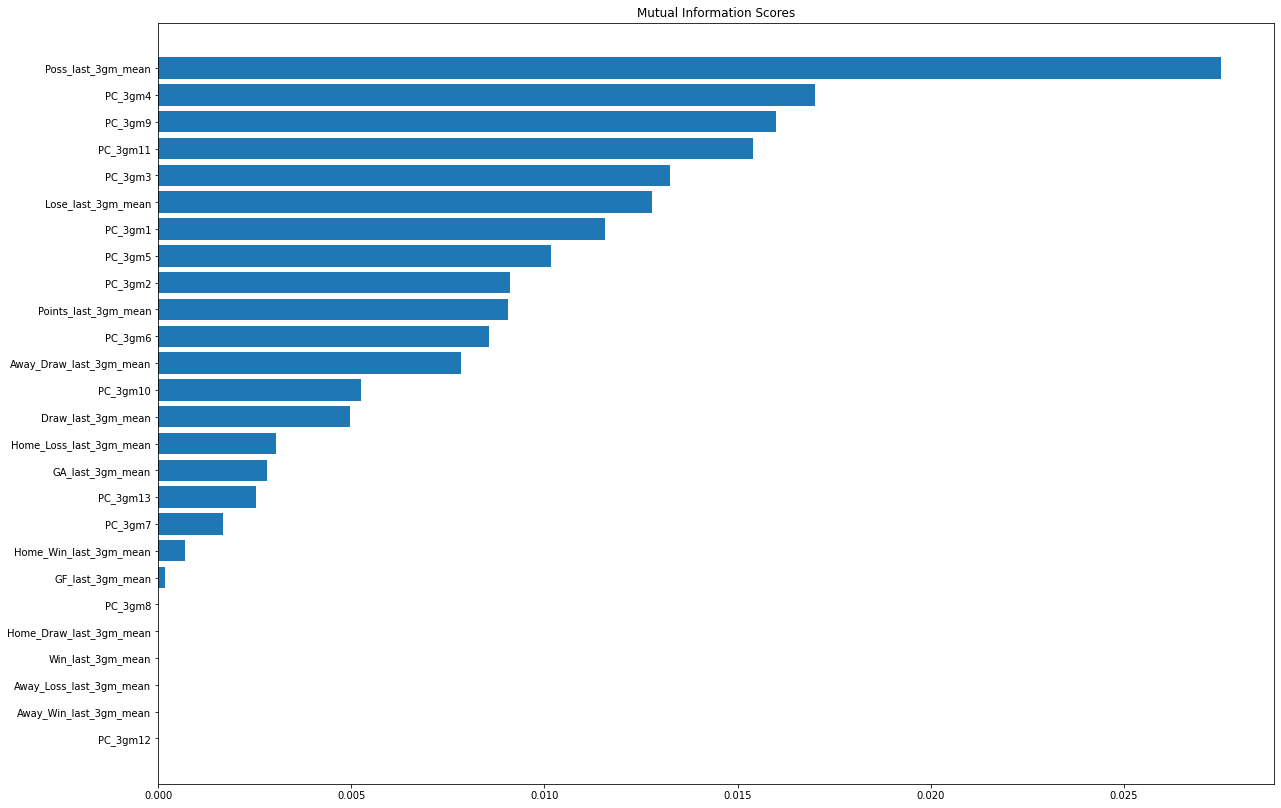

In [112]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_3gm.reset_index(drop=True),X_pca_3gm],axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_scores_win)

In [141]:
def l3gm_variable(new_df):
    new_df = new_df.copy()
    #new_df = Ratio(df_def=new_df,a='Win_last_3gm_mean',b='GA_last_3gm_mean',ratio_name='l3_Win/GA')
    ##new_df = Ratio(df_def=new_df,a='Win_last_3gm_mean',b='Lose_last_3gm_mean',ratio_name='l3_Win/Loss')
    #new_df = Ratio(df_def=new_df,a='Win_last_3gm_mean',b='Draw_last_3gm_mean',ratio_name='l3g_Win/Draw')
    new_df = Ratio(df_def=new_df,a='Lose_last_3gm_mean',b='GA_last_3gm_mean',ratio_name='l3g_Loss/GA')
    new_df = Ratio(df_def=new_df,a='Lose_last_3gm_mean',b='GF_last_3gm_mean',ratio_name='l3g_Loss/GF')
    new_df = Ratio(df_def=new_df,a='Draw_last_3gm_mean',b='GF_last_3gm_mean',ratio_name='l3g_Draw/GF')
    new_df = Ratio(df_def=new_df,a='Draw_last_3gm_mean',b='GA_last_3gm_mean',ratio_name='l3g_Draw/GA')
    new_df = Ratio(df_def=new_df,a='GF_last_3gm_mean',b='GA_last_3gm_mean',ratio_name='l3g_GF/GA')
    new_df['l3g_GF_GA+-'] = new_df.GF_last_3gm_mean - new_df.GA_last_3gm_mean
    return new_df

In [114]:
d1 = topk_feat(df=df4,mi_scores=mi_scores_win,PC=X_pca_3gm,cols=roll_3game,thresh=0,targets=targets)

In [138]:
d1

,Win,Draw,Lose,Points,Season,Poss_last_3gm_mean,PC_3gm4,PC_3gm9,PC_3gm11,PC_3gm3,Lose_last_3gm_mean,PC_3gm1,PC_3gm5,PC_3gm2,Points_last_3gm_mean,PC_3gm6,Away_Draw_last_3gm_mean,PC_3gm10,Draw_last_3gm_mean,Home_Loss_last_3gm_mean,GA_last_3gm_mean,PC_3gm13,PC_3gm7,Home_Win_last_3gm_mean,GF_last_3gm_mean
0,1,0,0,3,2018,65.333333,-1.943215,-0.011338,0.004355,0.778557,0.666667,-1.410345,-1.713291,-1.835921,1.000000,-0.799242,0.000000,0.002575,0.000000,0.000000,2.666667,1.573178e-14,0.481615,0.333333,1.333333
1,0,1,0,1,2018,60.333333,-2.086508,-0.008499,0.000876,-0.021767,0.333333,1.267021,-0.611767,-1.504618,2.000000,0.338193,0.000000,-0.000654,0.000000,0.000000,1.666667,2.047850e-14,0.361561,0.666667,2.000000
2,1,0,0,3,2018,59.000000,-1.548934,-0.006927,-0.006256,-1.646152,0.000000,2.387915,-0.073189,1.132981,2.333333,0.201100,0.333333,0.001134,0.333333,0.000000,0.333333,-1.135011e-16,-0.871591,0.666667,1.333333
3,1,0,0,3,2018,62.666667,-0.599375,-0.009100,-0.000641,-0.175566,0.000000,3.973371,-0.187615,-1.144941,3.000000,0.421223,0.000000,-0.000255,0.000000,0.000000,0.666667,-5.935570e-17,-0.171100,0.666667,2.333333
4,0,0,1,0,2018,64.666667,-0.607752,-0.009958,-0.000102,-0.163890,0.000000,4.142970,-0.459243,-1.186082,3.000000,0.433355,0.000000,-0.001632,0.000000,0.000000,0.666667,-5.906150e-17,0.036452,0.666667,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,0,0,1,0,2022,57.000000,-1.889870,-0.013798,0.000306,0.706527,0.666667,-1.168992,-0.503376,-1.399643,1.000000,-0.787001,0.000000,-0.001356,0.000000,0.000000,1.000000,-7.090092e-17,-1.383116,0.333333,0.666667
3775,0,1,0,1,2022,56.666667,-0.414142,-0.015019,0.002865,0.371919,1.000000,-3.819104,-1.105927,-1.668562,0.000000,-0.508000,0.000000,0.004291,0.000000,0.333333,1.666667,1.706769e-17,-1.446005,0.000000,0.000000
3776,0,0,1,0,2022,51.000000,0.107183,-0.008187,-0.000057,-1.224852,0.666667,-2.968878,-0.706860,0.482133,0.333333,-0.643041,0.333333,0.003914,0.333333,0.333333,2.000000,-1.115255e-16,-0.023430,0.000000,0.666667
3777,0,1,0,1,2022,40.666667,1.431268,-0.000180,0.001910,-2.345511,0.666667,-3.603164,-0.048885,0.170905,0.333333,0.742242,0.333333,0.009369,0.333333,0.666667,3.333333,-1.097198e-16,1.706413,0.000000,1.000000


In [142]:
d2 = l3gm_variable(new_df=d1)

In [115]:
first_batch2 = predictions(data=d1,predictors=d1.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6016150740242261



predicted_Win,0.0,1.0
actual,,
0,392,55
1,241,55


Win Precision :  0.5
Win F1_score :  0.270935960591133
Win ROC :  0.5313841526089849


Draw Accuracy Score :  0.765814266487214



predicted_Draw,0.0,1.0
actual,,
0,569,1
1,173,0


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.49912280701754386


Lose Accuracy Score :  0.6056527590847914



predicted_Lose,0.0,1.0
actual,,
0,431,38
1,255,19


Lose Precision :  0.3333333333333333
Lose F1_score :  0.1148036253776435
Lose ROC :  0.49415980576782403


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [143]:
first_batch2 = predictions(data=d2,predictors=d2.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6029609690444145



predicted_Win,0.0,1.0
actual,,
0,390,57
1,238,58


Win Precision :  0.5043478260869565
Win F1_score :  0.2822384428223844
Win ROC :  0.534214583711228


Draw Accuracy Score :  0.765814266487214



predicted_Draw,0.0,1.0
actual,,
0,569,1
1,173,0


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.49912280701754386


Lose Accuracy Score :  0.6110363391655451



predicted_Lose,0.0,1.0
actual,,
0,436,33
1,256,18


Lose Precision :  0.35294117647058826
Lose F1_score :  0.11076923076923077
Lose ROC :  0.4976654786546932


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [144]:
a_b_c_d = pd.concat([a_b_c.drop(targets+['Season'],axis=1),d2],axis=1)
a_b_c_d.head(2)

,PC_total2,Total_GF,PC_total5,PC_total1,Total_Win,Total_Points,Total_Draw,Total_Loss,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Draw/GF,Loss_Avg_for_szn,PC_szn_avg1,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,PC_szn_avg4,PC_szn_avg3,Draw_Avg_for_szn,PC_szn_avg2,PC_szn_avg5,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-,Away_Win_last_2gm_sum,PC_2gm8,PC_2gm1,GA_last_2gm_sum,PC_2gm7,Win_last_2gm_sum,PC_2gm4,PC_2gm2,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,GF_last_2gm_sum,PC_2gm3,PC_2gm11,PC_2gm9,Lose_last_2gm_sum,PC_2gm6,PC_2gm5,PC_2gm12,Draw_last_2gm_sum,PC_2gm10,Home_Loss_last_2gm_sum,l2_Win/GA,l2_Win/GF,l2_Win/Loss,l2g_Win/Draw,l2g_Loss/GA,l2g_Loss/GF,l2g_Draw/GF,l2g_Draw/GA,l2g_GF/GA,l2g_GF_GA+-,Win,Draw,Lose,Points,Season,Poss_last_3gm_mean,PC_3gm4,PC_3gm9,PC_3gm11,PC_3gm3,Lose_last_3gm_mean,PC_3gm1,PC_3gm5,PC_3gm2,Points_last_3gm_mean,PC_3gm6,Away_Draw_last_3gm_mean,PC_3gm10,Draw_last_3gm_mean,Home_Loss_last_3gm_mean,GA_last_3gm_mean,PC_3gm13,PC_3gm7,Home_Win_last_3gm_mean,GF_last_3gm_mean,l3g_Loss/GA,l3g_Loss/GF,l3g_Draw/GF,l3g_Draw/GA,l3g_GF/GA,l3g_GF_GA+-
0,-0.528511,5.0,0.040984,-3.039429,1.0,4.0,1.0,2.0,4.000000,2.0,4.0,0.800000,0.5,1.0,0.5,0.200000,0.200000,0.500000,-2.549352,1.000000,1.250000,2.250000,0.25,-0.488050,1.472260,0.250000,-0.389574,2.496314e-14,4.000000,2.0,0.800000,0.444444,0.111111,0.200000,0.5,1.0,0.222222,0.400000,0.200000,0.111111,0.555556,-1.000000,0.0,-0.008231,-3.672907,5.0,-0.233234,0.0,1.212043,-1.502376,2.0,0.0,0.0,-1.275876,4.675781e-13,-0.002323,2.0,-0.392406,-1.544597,1.002608e-15,0.0,0.001595,0.0,0.0,0.000000,0.0,0.0,0.4,0.0,0.0,0.0,0.0,-5.0,1,0,0,3,2018,65.333333,-1.943215,-0.011338,0.004355,0.778557,0.666667,-1.410345,-1.713291,-1.835921,1.0,-0.799242,0.0,0.002575,0.0,0.0,2.666667,1.573178e-14,0.481615,0.333333,1.333333,0.25,0.500000,0.0,0.0,0.5,-1.333333
1,-0.704516,11.0,0.043462,-2.718043,3.0,10.0,1.0,2.0,3.333333,5.0,10.0,0.909091,1.5,3.0,0.5,0.272727,0.090909,0.333333,0.216998,1.666667,1.833333,1.666667,0.50,-0.331915,0.956871,0.166667,-0.810921,1.025364e-16,3.333333,5.0,0.909091,1.000000,0.300000,0.272727,1.5,3.0,0.200000,0.181818,0.090909,0.100000,1.100000,0.166667,0.0,-0.007532,3.487078,1.0,0.175127,2.0,-0.733380,-1.015318,0.0,2.0,6.0,-1.834498,-7.343836e-15,0.004520,0.0,0.250175,1.048458,6.007665e-14,0.0,-0.002703,0.0,2.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0,1,0,1,2018,60.333333,-2.086508,-0.008499,0.000876,-0.021767,0.333333,1.267021,-0.611767,-1.504618,2.0,0.338193,0.0,-0.000654,0.0,0.0,1.666667,2.047850e-14,0.361561,0.666667,2.000000,0.20,0.166667,0.0,0.0,1.2,0.333333


In [117]:
first_batch2 = predictions(data=a_b_c_d,predictors=a_b_c_d.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6271870794078062



predicted_Win,0.0,1.0
actual,,
0,404,43
1,234,62


Win Precision :  0.5904761904761905
Win F1_score :  0.3092269326683292
Win ROC :  0.5566312957252554


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.6352624495289367



predicted_Lose,0.0,1.0
actual,,
0,450,19
1,252,22


Lose Precision :  0.5365853658536586
Lose F1_score :  0.13968253968253969
Lose ROC :  0.5198901218620142


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [145]:
first_batch2 = predictions(data=a_b_c_d,predictors=a_b_c_d.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6406460296096904



predicted_Win,0.0,1.0
actual,,
0,412,35
1,232,64


Win Precision :  0.6464646464646465
Win F1_score :  0.3240506329113924
Win ROC :  0.5689582199649313


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.6325706594885598



predicted_Lose,0.0,1.0
actual,,
0,452,17
1,256,18


Lose Precision :  0.5142857142857142
Lose F1_score :  0.11650485436893203
Lose ROC :  0.5147230479510685


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [134]:
first_batch2 = predictions(data=a_b_c_d,predictors=a_b_c_d.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6271870794078062



predicted_Win,0.0,1.0
actual,,
0,404,43
1,234,62


Win Precision :  0.5904761904761905
Win F1_score :  0.3092269326683292
Win ROC :  0.5566312957252554


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.6352624495289367



predicted_Lose,0.0,1.0
actual,,
0,450,19
1,252,22


Lose Precision :  0.5365853658536586
Lose F1_score :  0.13968253968253969
Lose ROC :  0.5198901218620142


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [118]:
this_month = 'GF_this_month_sum	GA_this_month_sum	Away_Win_this_month_sum	Away_Draw_this_month_sum	Away_Loss_this_month_sum	Home_Win_this_month_sum	Home_Draw_this_month_sum	Home_Loss_this_month_sum'.split('	')
this_month

['GF_this_month_sum',
 'GA_this_month_sum',
 'Away_Win_this_month_sum',
 'Away_Draw_this_month_sum',
 'Away_Loss_this_month_sum',
 'Home_Win_this_month_sum',
 'Home_Draw_this_month_sum',
 'Home_Loss_this_month_sum']

In [119]:
X_this_month = df4.loc[:,this_month] 

In [120]:
pca_this_month, X_pca_this_month, loadings_this_month = apply_pca(X=X_this_month,alias='this_month')
display(loadings_this_month)

,PC_this_month1,PC_this_month2,PC_this_month3,PC_this_month4,PC_this_month5,PC_this_month6,PC_this_month7,PC_this_month8
GF_this_month_sum,0.648964,0.139812,-0.002334,-0.037025,0.002912,0.041925,0.276618,0.692559
GA_this_month_sum,0.081028,0.690365,0.071496,0.022951,0.001010,-0.065842,0.563615,-0.434964
Away_Win_this_month_sum,0.489924,-0.046445,-0.118388,-0.030589,0.561617,-0.497291,-0.293216,-0.306885
Away_Draw_this_month_sum,0.132658,0.029044,0.583970,0.612462,-0.347128,-0.329824,-0.190109,0.001898
Away_Loss_this_month_sum,-0.146379,0.531816,-0.110148,-0.416558,-0.324596,-0.365464,-0.472307,0.219297
Home_Win_this_month_sum,0.526897,-0.006085,-0.190506,-0.046656,-0.474296,0.456301,-0.298381,-0.402088
Home_Draw_this_month_sum,0.055714,0.083497,0.750669,-0.445781,0.278498,0.341085,-0.179314,-0.040564
Home_Loss_this_month_sum,-0.111829,0.459359,-0.167082,0.497633,0.395219,0.423923,-0.373422,0.159922


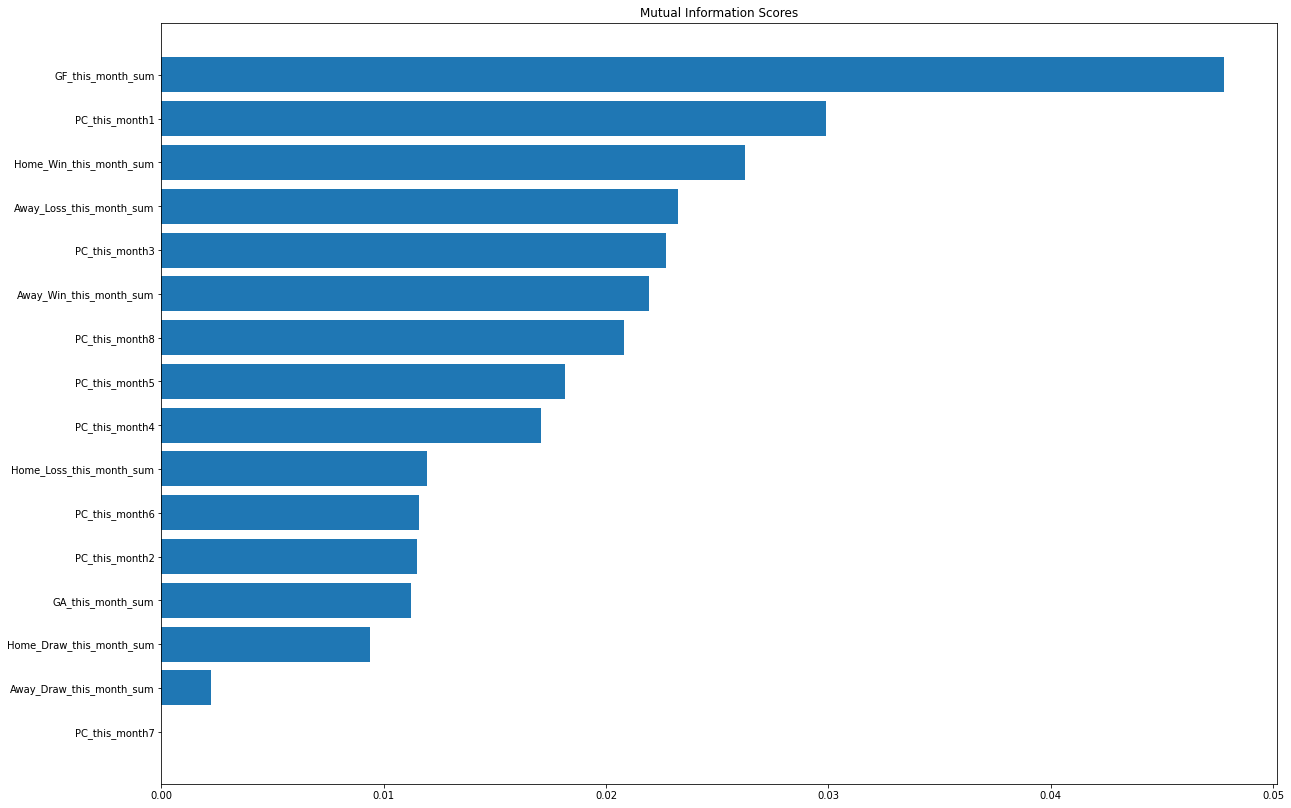

In [146]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_this_month.reset_index(drop=True),X_pca_this_month],axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_scores_win)

In [147]:
e1 = topk_feat(df=df4,mi_scores=mi_scores_win,PC=X_pca_this_month,cols=this_month,thresh=0,targets=targets)

In [148]:
e1.head()

,Win,Draw,Lose,Points,Season,GF_this_month_sum,PC_this_month1,Home_Win_this_month_sum,Away_Loss_this_month_sum,PC_this_month3,Away_Win_this_month_sum,PC_this_month8,PC_this_month5,PC_this_month4,Home_Loss_this_month_sum,PC_this_month6,PC_this_month2,GA_this_month_sum,Home_Draw_this_month_sum,Away_Draw_this_month_sum
0,1,0,0,3,2018,6.2,1.247625,2.4,0.0,-0.259535,0.0,-0.077391,-1.744989,0.509069,0.0,1.010183,-1.384064,0.8,0.0,0.6
1,0,1,0,1,2018,6.0,0.806173,2.0,0.0,-0.840860,0.0,0.048247,-1.108577,-0.177576,0.0,1.163685,-1.371832,1.0,0.0,0.0
2,1,0,0,3,2018,7.0,1.883085,3.0,0.0,0.058576,0.0,-0.254340,-2.362194,0.943963,0.0,1.093548,-1.285359,1.0,0.0,1.0
3,1,0,0,3,2018,5.8,0.818158,1.2,0.8,-0.908711,1.0,-0.022178,-0.237925,-0.651571,0.0,-0.454659,-0.405657,2.6,0.0,0.0
4,0,0,1,0,2018,2.0,-0.565968,1.0,0.0,-0.631290,0.0,-0.044267,-0.531351,-0.089074,0.0,0.584064,-1.767524,0.0,0.0,0.0


In [149]:
first_batch2 = predictions(data=e1,predictors=e1.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6473755047106325



predicted_Win,0.0,1.0
actual,,
0,394,53
1,209,87


Win Precision :  0.6214285714285714
Win F1_score :  0.39908256880733944
Win ROC :  0.5876753431283632


Draw Accuracy Score :  0.7806191117092867



predicted_Draw,0.0,1.0
actual,,
0,567,3
1,160,13


Draw Precision :  0.8125
Draw F1_score :  0.13756613756613756
Draw ROC :  0.5349406753878917


Lose Accuracy Score :  0.6742934051144011



predicted_Lose,0.0,1.0
actual,,
0,422,47
1,195,79


Lose Precision :  0.626984126984127
Lose F1_score :  0.395
Lose ROC :  0.5940539741335036


Points Accuracy Score :  0.3781965006729475



predicted_Points,0.0,1.0
actual,,
0,271,3
1,163,10
3,296,0


Points Precision _Macro_Micro :  0.3801545486476994 0.3781965006729475
Points F1_score _Macro_Micro :  0.21578917305687642 0.3781965006729475




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [150]:
e1.columns

Index(['Win', 'Draw', 'Lose', 'Points', 'Season', 'GF_this_month_sum',
       'PC_this_month1', 'Home_Win_this_month_sum', 'Away_Loss_this_month_sum',
       'PC_this_month3', 'Away_Win_this_month_sum', 'PC_this_month8',
       'PC_this_month5', 'PC_this_month4', 'Home_Loss_this_month_sum',
       'PC_this_month6', 'PC_this_month2', 'GA_this_month_sum',
       'Home_Draw_this_month_sum', 'Away_Draw_this_month_sum'],
      dtype='object')

In [157]:
def this_month_variable(new_df):
    new_df = new_df.copy()
    #new_df = Ratio(df_def=new_df,a='Win_this_month_sum',b='GA_this_month_sum',ratio_name='this_month_sum_Win/GA')
    #new_df = Ratio(df_def=new_df,a='Win_this_month_sum',b='Lose_this_month_sum',ratio_name='this_month_sum_Win/Loss')
    #new_df = Ratio(df_def=new_df,a='Win_this_month_sum',b='Draw_this_month_sum',ratio_name='this_month_sum_Win/Draw')
    #new_df = Ratio(df_def=new_df,a='Lose_this_month_sum',b='GA_this_month_sum',ratio_name='this_month_sum_Loss/GA')
    #new_df = Ratio(df_def=new_df,a='Lose_this_month_sum',b='GF_this_month_sum',ratio_name='this_month_sum_Loss/GF')
    #new_df = Ratio(df_def=new_df,a='Draw_this_month_sum',b='GF_this_month_sum',ratio_name='this_month_sum_Draw/GF')
    #new_df = Ratio(df_def=new_df,a='Draw_this_month_sum',b='GA_this_month_sum',ratio_name='this_month_sum_Draw/GA')
    new_df = Ratio(df_def=new_df,a='GF_this_month_sum',b='GA_this_month_sum',ratio_name='this_month_sum_GF/GA')
    new_df['this_month_sum_GF_GA+-'] = new_df.GF_this_month_sum - new_df.GA_this_month_sum
    return new_df

In [158]:
e2 = this_month_variable(new_df=e1)

In [159]:
first_batch2 = predictions(data=e2,predictors=e2.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6433378196500673



predicted_Win,0.0,1.0
actual,,
0,395,52
1,213,83


Win Precision :  0.6148148148148148
Win F1_score :  0.3851508120649652
Win ROC :  0.5820371546042687


Draw Accuracy Score :  0.7792732166890982



predicted_Draw,0.0,1.0
actual,,
0,566,4
1,160,13


Draw Precision :  0.7647058823529411
Draw F1_score :  0.1368421052631579
Draw ROC :  0.5340634824054356


Lose Accuracy Score :  0.6662180349932705



predicted_Lose,0.0,1.0
actual,,
0,420,49
1,199,75


Lose Precision :  0.6048387096774194
Lose F1_score :  0.37688442211055273
Lose ROC :  0.5846225078984639


Points Accuracy Score :  0.3768506056527591



predicted_Points,0.0,1.0
actual,,
0,272,2
1,165,8
3,296,0


Points Precision _Macro_Micro :  0.3903592542064575 0.3768506056527591
Points F1_score _Macro_Micro :  0.20921672156471185 0.37685060565275913




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

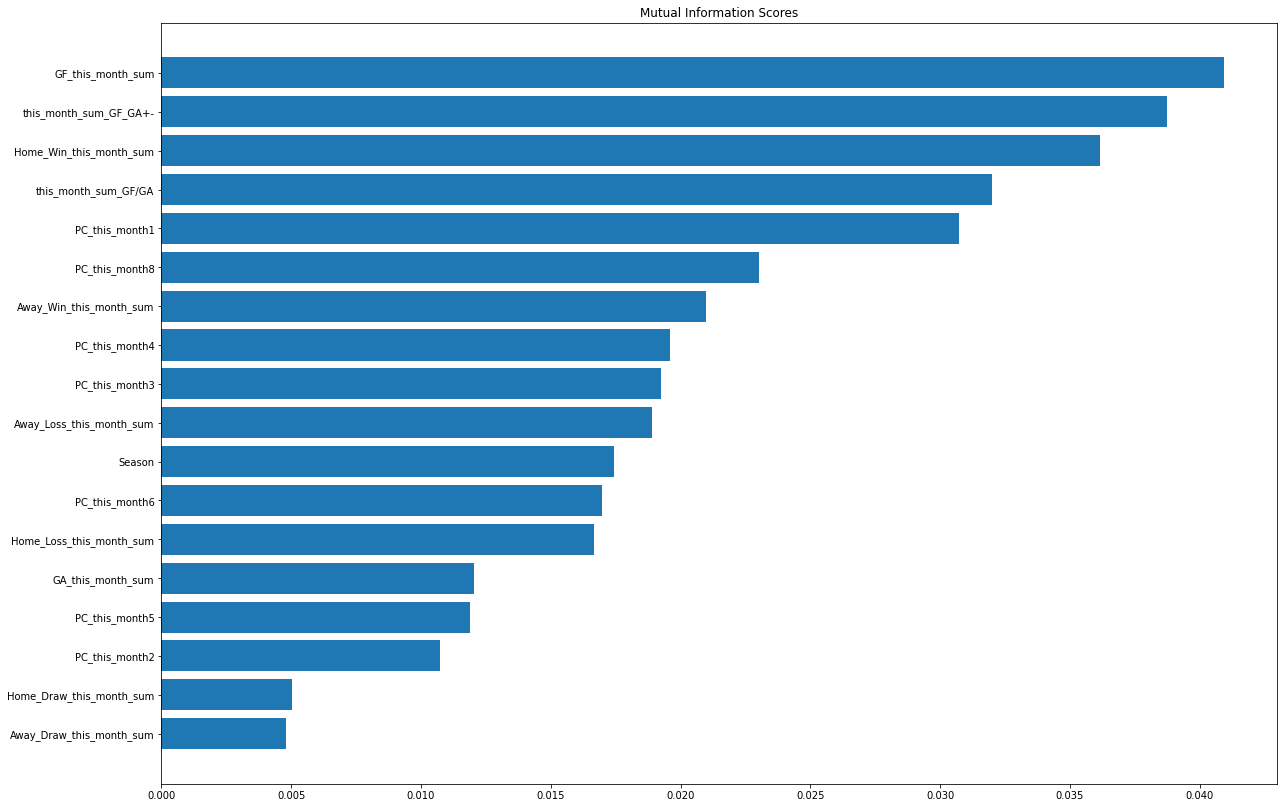

In [160]:
#win
mi_ = make_mi_scores_Classif(X_train=e2.drop(targets,axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_)

In [163]:
a_b_c_d_e = pd.concat([a_b_c_d.drop(targets+['Season'],axis=1),e2],axis=1)
a_b_c_d_e.head(2)

,PC_total2,Total_GF,PC_total5,PC_total1,Total_Win,Total_Points,Total_Draw,Total_Loss,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Draw/GF,Loss_Avg_for_szn,PC_szn_avg1,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,PC_szn_avg4,PC_szn_avg3,Draw_Avg_for_szn,PC_szn_avg2,PC_szn_avg5,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-,Away_Win_last_2gm_sum,PC_2gm8,PC_2gm1,GA_last_2gm_sum,PC_2gm7,Win_last_2gm_sum,PC_2gm4,PC_2gm2,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,GF_last_2gm_sum,PC_2gm3,PC_2gm11,PC_2gm9,Lose_last_2gm_sum,PC_2gm6,PC_2gm5,PC_2gm12,Draw_last_2gm_sum,PC_2gm10,Home_Loss_last_2gm_sum,l2_Win/GA,l2_Win/GF,l2_Win/Loss,l2g_Win/Draw,l2g_Loss/GA,l2g_Loss/GF,l2g_Draw/GF,l2g_Draw/GA,l2g_GF/GA,l2g_GF_GA+-,Poss_last_3gm_mean,PC_3gm4,PC_3gm9,PC_3gm11,PC_3gm3,Lose_last_3gm_mean,PC_3gm1,PC_3gm5,PC_3gm2,Points_last_3gm_mean,PC_3gm6,Away_Draw_last_3gm_mean,PC_3gm10,Draw_last_3gm_mean,Home_Loss_last_3gm_mean,GA_last_3gm_mean,PC_3gm13,PC_3gm7,Home_Win_last_3gm_mean,GF_last_3gm_mean,l3g_Loss/GA,l3g_Loss/GF,l3g_Draw/GF,l3g_Draw/GA,l3g_GF/GA,l3g_GF_GA+-,Win,Draw,Lose,Points,Season,GF_this_month_sum,PC_this_month1,Home_Win_this_month_sum,Away_Loss_this_month_sum,PC_this_month3,Away_Win_this_month_sum,PC_this_month8,PC_this_month5,PC_this_month4,Home_Loss_this_month_sum,PC_this_month6,PC_this_month2,GA_this_month_sum,Home_Draw_this_month_sum,Away_Draw_this_month_sum,this_month_sum_GF/GA,this_month_sum_GF_GA+-
0,-0.528511,5.0,0.040984,-3.039429,1.0,4.0,1.0,2.0,4.000000,2.0,4.0,0.800000,0.5,1.0,0.5,0.200000,0.200000,0.500000,-2.549352,1.000000,1.250000,2.250000,0.25,-0.488050,1.472260,0.250000,-0.389574,2.496314e-14,4.000000,2.0,0.800000,0.444444,0.111111,0.200000,0.5,1.0,0.222222,0.400000,0.200000,0.111111,0.555556,-1.000000,0.0,-0.008231,-3.672907,5.0,-0.233234,0.0,1.212043,-1.502376,2.0,0.0,0.0,-1.275876,4.675781e-13,-0.002323,2.0,-0.392406,-1.544597,1.002608e-15,0.0,0.001595,0.0,0.0,0.000000,0.0,0.0,0.4,0.0,0.0,0.0,0.0,-5.0,65.333333,-1.943215,-0.011338,0.004355,0.778557,0.666667,-1.410345,-1.713291,-1.835921,1.0,-0.799242,0.0,0.002575,0.0,0.0,2.666667,1.573178e-14,0.481615,0.333333,1.333333,0.25,0.500000,0.0,0.0,0.5,-1.333333,1,0,0,3,2018,6.2,1.247625,2.4,0.0,-0.259535,0.0,-0.077391,-1.744989,0.509069,0.0,1.010183,-1.384064,0.8,0.0,0.6,7.75,5.4
1,-0.704516,11.0,0.043462,-2.718043,3.0,10.0,1.0,2.0,3.333333,5.0,10.0,0.909091,1.5,3.0,0.5,0.272727,0.090909,0.333333,0.216998,1.666667,1.833333,1.666667,0.50,-0.331915,0.956871,0.166667,-0.810921,1.025364e-16,3.333333,5.0,0.909091,1.000000,0.300000,0.272727,1.5,3.0,0.200000,0.181818,0.090909,0.100000,1.100000,0.166667,0.0,-0.007532,3.487078,1.0,0.175127,2.0,-0.733380,-1.015318,0.0,2.0,6.0,-1.834498,-7.343836e-15,0.004520,0.0,0.250175,1.048458,6.007665e-14,0.0,-0.002703,0.0,2.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,60.333333,-2.086508,-0.008499,0.000876,-0.021767,0.333333,1.267021,-0.611767,-1.504618,2.0,0.338193,0.0,-0.000654,0.0,0.0,1.666667,2.047850e-14,0.361561,0.666667,2.000000,0.20,0.166667,0.0,0.0,1.2,0.333333,0,1,0,1,2018,6.0,0.806173,2.0,0.0,-0.840860,0.0,0.048247,-1.108577,-0.177576,0.0,1.163685,-1.371832,1.0,0.0,0.0,6.00,5.0


In [162]:
    first_batch2 = predictions(data=a_b_c_d_e,predictors=a_b_c_d_e.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6473755047106325



predicted_Win,0.0,1.0
actual,,
0,411,36
1,226,70


Win Precision :  0.660377358490566
Win F1_score :  0.34825870646766166
Win ROC :  0.5779747868674042


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.6527590847913862



predicted_Lose,0.0,1.0
actual,,
0,458,11
1,247,27


Lose Precision :  0.7105263157894737
Lose F1_score :  0.1730769230769231
Lose ROC :  0.5375429941014427


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [164]:
    first_batch2 = predictions(data=a_b_c_d_e,predictors=a_b_c_d_e.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6446837146702558



predicted_Win,0.0,1.0
actual,,
0,411,36
1,228,68


Win Precision :  0.6538461538461539
Win F1_score :  0.3400000000000001
Win ROC :  0.5745964084890259


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.6541049798115747



predicted_Lose,0.0,1.0
actual,,
0,453,16
1,241,33


Lose Precision :  0.673469387755102
Lose F1_score :  0.2043343653250774
Lose ROC :  0.5431614088058145


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [165]:
prev_month = 'GF_sum_prev_month_	GA_sum_prev_month_	Away_Win_sum_prev_month_	Away_Draw_sum_prev_month_	Away_Loss_sum_prev_month_	Home_Win_sum_prev_month_	Home_Draw_sum_prev_month_	Home_Loss_sum_prev_month_'.split('	')
prev_month

['GF_sum_prev_month_',
 'GA_sum_prev_month_',
 'Away_Win_sum_prev_month_',
 'Away_Draw_sum_prev_month_',
 'Away_Loss_sum_prev_month_',
 'Home_Win_sum_prev_month_',
 'Home_Draw_sum_prev_month_',
 'Home_Loss_sum_prev_month_']

In [166]:
X_prev_month = df4.loc[:,prev_month] 

In [167]:
pca_prev_month, X_pca_prev_month, loadings_prev_month = apply_pca(X=X_prev_month,alias='prev_month')
display(loadings_prev_month)

,PC_prev_month1,PC_prev_month2,PC_prev_month3,PC_prev_month4,PC_prev_month5,PC_prev_month6,PC_prev_month7,PC_prev_month8
GF_sum_prev_month_,0.487759,0.466660,-0.011622,0.127098,0.053274,-0.046711,0.179361,0.700600
GA_sum_prev_month_,-0.323613,0.625580,-0.007808,0.271595,0.093506,0.080288,0.522737,-0.376374
Away_Win_sum_prev_month_,0.431600,0.199670,-0.167952,-0.177213,0.518613,0.497001,-0.292825,-0.335448
Away_Draw_sum_prev_month_,0.072687,-0.102761,0.568509,0.687980,-0.080598,0.359127,-0.228227,-0.009034
Away_Loss_sum_prev_month_,-0.390459,0.369921,-0.338891,-0.018747,-0.417389,0.345786,-0.508325,0.208148
Home_Win_sum_prev_month_,0.437633,0.326213,0.120748,-0.017703,-0.471410,-0.442997,-0.273250,-0.440487
Home_Draw_sum_prev_month_,0.015844,-0.120196,-0.595350,0.624137,0.257311,-0.363115,-0.202838,-0.045920
Home_Loss_sum_prev_month_,-0.348672,0.287658,0.405616,-0.123082,0.500312,-0.409540,-0.427245,0.124229


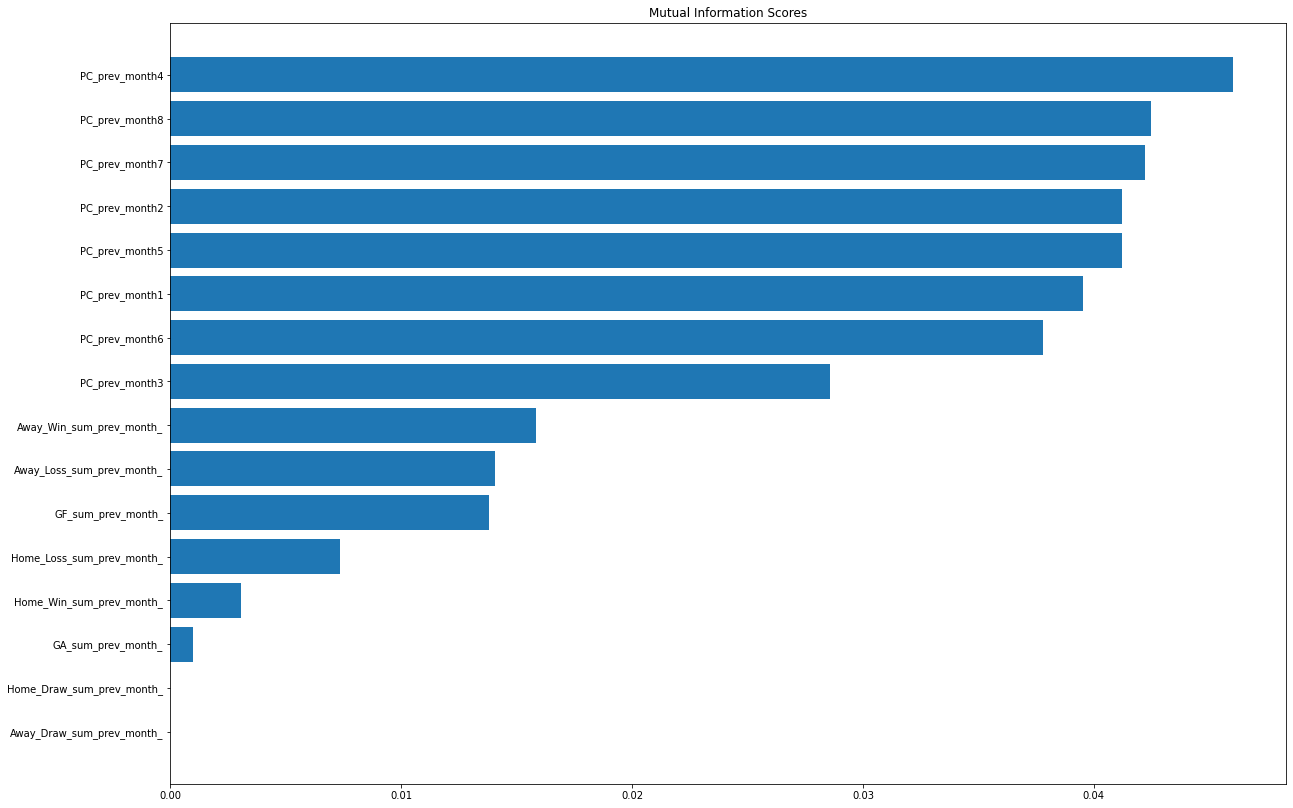

In [168]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_prev_month.reset_index(drop=True),X_pca_prev_month],axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_scores_win)

In [169]:
f1 = topk_feat(df=df4,mi_scores=mi_scores_win,PC=X_pca_prev_month,cols=prev_month,thresh=0,targets=targets)

In [170]:
first_batch2 = predictions(data=f1,predictors=f1.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6096904441453567



predicted_Win,0.0,1.0
actual,,
0,420,27
1,263,33


Win Precision :  0.55
Win F1_score :  0.1853932584269663
Win ROC :  0.525541900961364


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.639300134589502



predicted_Lose,0.0,1.0
actual,,
0,467,2
1,266,8


Lose Precision :  0.8
Lose F1_score :  0.056338028169014086
Lose ROC :  0.5124663439839385


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [171]:
a_b_c_d_e_f = pd.concat([a_b_c_d_e.drop(targets+['Season'],axis=1),f1],axis=1)
a_b_c_d_e_f.head(2)

,PC_total2,Total_GF,PC_total5,PC_total1,Total_Win,Total_Points,Total_Draw,Total_Loss,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Draw/GF,Loss_Avg_for_szn,PC_szn_avg1,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,PC_szn_avg4,PC_szn_avg3,Draw_Avg_for_szn,PC_szn_avg2,PC_szn_avg5,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-,Away_Win_last_2gm_sum,PC_2gm8,PC_2gm1,GA_last_2gm_sum,PC_2gm7,Win_last_2gm_sum,PC_2gm4,PC_2gm2,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,GF_last_2gm_sum,PC_2gm3,PC_2gm11,PC_2gm9,Lose_last_2gm_sum,PC_2gm6,PC_2gm5,PC_2gm12,Draw_last_2gm_sum,PC_2gm10,Home_Loss_last_2gm_sum,l2_Win/GA,l2_Win/GF,l2_Win/Loss,l2g_Win/Draw,l2g_Loss/GA,l2g_Loss/GF,l2g_Draw/GF,l2g_Draw/GA,l2g_GF/GA,l2g_GF_GA+-,Poss_last_3gm_mean,PC_3gm4,PC_3gm9,PC_3gm11,PC_3gm3,Lose_last_3gm_mean,PC_3gm1,PC_3gm5,PC_3gm2,Points_last_3gm_mean,PC_3gm6,Away_Draw_last_3gm_mean,PC_3gm10,Draw_last_3gm_mean,Home_Loss_last_3gm_mean,GA_last_3gm_mean,PC_3gm13,PC_3gm7,Home_Win_last_3gm_mean,GF_last_3gm_mean,l3g_Loss/GA,l3g_Loss/GF,l3g_Draw/GF,l3g_Draw/GA,l3g_GF/GA,l3g_GF_GA+-,GF_this_month_sum,PC_this_month1,Home_Win_this_month_sum,Away_Loss_this_month_sum,PC_this_month3,Away_Win_this_month_sum,PC_this_month8,PC_this_month5,PC_this_month4,Home_Loss_this_month_sum,PC_this_month6,PC_this_month2,GA_this_month_sum,Home_Draw_this_month_sum,Away_Draw_this_month_sum,this_month_sum_GF/GA,this_month_sum_GF_GA+-,Win,Draw,Lose,Points,Season,PC_prev_month4,PC_prev_month8,PC_prev_month7,PC_prev_month2,PC_prev_month5,PC_prev_month1,PC_prev_month6,PC_prev_month3,Away_Win_sum_prev_month_,Away_Loss_sum_prev_month_,GF_sum_prev_month_,Home_Loss_sum_prev_month_,Home_Win_sum_prev_month_,GA_sum_prev_month_
0,-0.528511,5.0,0.040984,-3.039429,1.0,4.0,1.0,2.0,4.000000,2.0,4.0,0.800000,0.5,1.0,0.5,0.200000,0.200000,0.500000,-2.549352,1.000000,1.250000,2.250000,0.25,-0.488050,1.472260,0.250000,-0.389574,2.496314e-14,4.000000,2.0,0.800000,0.444444,0.111111,0.200000,0.5,1.0,0.222222,0.400000,0.200000,0.111111,0.555556,-1.000000,0.0,-0.008231,-3.672907,5.0,-0.233234,0.0,1.212043,-1.502376,2.0,0.0,0.0,-1.275876,4.675781e-13,-0.002323,2.0,-0.392406,-1.544597,1.002608e-15,0.0,0.001595,0.0,0.0,0.000000,0.0,0.0,0.4,0.0,0.0,0.0,0.0,-5.0,65.333333,-1.943215,-0.011338,0.004355,0.778557,0.666667,-1.410345,-1.713291,-1.835921,1.0,-0.799242,0.0,0.002575,0.0,0.0,2.666667,1.573178e-14,0.481615,0.333333,1.333333,0.25,0.500000,0.0,0.0,0.5,-1.333333,6.2,1.247625,2.4,0.0,-0.259535,0.0,-0.077391,-1.744989,0.509069,0.0,1.010183,-1.384064,0.8,0.0,0.6,7.75,5.4,1,0,0,3,2018,1.981857,0.208433,0.182255,2.394175,-1.96765,-0.840731,0.506245,-1.015265,0.0,3.0,12.0,0.0,2.0,13.0
1,-0.704516,11.0,0.043462,-2.718043,3.0,10.0,1.0,2.0,3.333333,5.0,10.0,0.909091,1.5,3.0,0.5,0.272727,0.090909,0.333333,0.216998,1.666667,1.833333,1.666667,0.50,-0.331915,0.956871,0.166667,-0.810921,1.025364e-16,3.333333,5.0,0.909091,1.000000,0.300000,0.272727,1.5,3.0,0.200000,0.181818,0.090909,0.100000,1.100000,0.166667,0.0,-0.007532,3.487078,1.0,0.175127,2.0,-0.733380,-1.015318,0.0,2.0,6.0,-1.834498,-7.343836e-15,0.004520,0.0,0.250175,1.048458,6.007665e-14,0.0,-0.002703,0.0,2.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,60.333333,-2.086508,-0.008499,0.000876,-0.021767,0.333333,1.267021,-0.611767,-1.504618,2.0,0.338193,0.0,-0.000654,0.0,0.0,1.666667,2.047850e-14,0.361561,0.666667,2.000000,0.20,0.166667,0.0,0.0,1.2,0.333333,6.0,0.806173,2.0,0.0,-0.840860,0.0,0.048247,-1.108577,-0.177576,0.0,1.163685,-1.371832,1.0,0.0,0.0,6.00,5.0,0,1,0,1,2018,1.981857,0.208433,0.182255,2.394175,-1.96765,-0.840731,0.506245,-1.015265,0.0,3.0,12.0,0.0,2.0,13.0


In [172]:
    first_batch2 = predictions(data=a_b_c_d_e_f,predictors=a_b_c_d_e_f.columns.drop(targets),targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6460296096904441



predicted_Win,0.0,1.0
actual,,
0,415,32
1,231,65


Win Precision :  0.6701030927835051
Win F1_score :  0.3307888040712468
Win ROC :  0.5740031138521071


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.6500672947510094



predicted_Lose,0.0,1.0
actual,,
0,457,12
1,248,26


Lose Precision :  0.6842105263157895
Lose F1_score :  0.16666666666666666
Lose ROC :  0.5346520785021711


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




KeyError: "None of [Index(['Team', 'Opponent', 'Result'], dtype='object')] are in the [columns]"

In [ ]:
def get_PCA_cols(df,target)
    df = df.copy()
    new_df_dict = {}
    for columns,col_name in zip([]):
        X_present = 'X_'+col_name
        print(X_present)
        X_present = df.loc[:,columns]
        pca_, X_pca_, loadings_ = apply_pca(X=X_present,alias=col_name)
        display(loadings_prev_month)
        #win
        mi_scores_ = make_mi_scores_Classif(X_train=pd.concat([X_present.reset_index(drop=True),X_pca_],axis=1), y_train=df4[target])
        plot_mi_scores(scores=mi_scores_)
        new = topk_feat(df=df,mi_scores=mi_scores_,PC=X_pca_,cols=columns,thresh=0,targets=targets)
        new_df_dict[col_name] = new
        return new_df_dict